<a href="https://colab.research.google.com/github/yeticheese/thetagamma_analysis/blob/master/notebooks/Theta_Gamma_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install emd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Initialzing and loading required libraries and subfunctions
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.interpolate import griddata
import copy
import scipy.fft
import scipy.stats
import numpy as np
import emd as emd
import scipy.io as sio
import seaborn as sns
import pandas as pd

## Sleep Extraction

In this segment the Rat4 SD1 Dataset is loaded and the sleep states using the provided ES states file are identified utilising the ```sleep['transitions']``` key in the ```states.mat``` file.
- First we load the hippocampal readings and the REM states .mat files
- Scale the ```sleep['transitions]``` timestamps into it's appropiate size with respect to the sampling rate either downsampled or native of the recording device.


In [ ]:
lfp=sio.loadmat(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/HPC_100_CH42_0.continuous.mat')['HPC']
lfp=np.transpose(lfp)
sleep=sio.loadmat(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/2022-02-08_14-47-29_posttrial5-states_TS.mat')
states=sleep['states']
transitions=sleep['transitions']
sleep_transitions=transitions[transitions[:,0]==5][:,-2:]
lfp=lfp[0]
sleep_trans=np.floor(sleep_transitions*2500)

A simple REM extraction function to extract the individual REM epochs and generate a seperate array of the respective amplitudes at the extracted timestamps.



In [ ]:
def remextract(x,y):
    remsleep=y
    REM=[]
    for i,rem in enumerate(remsleep):
        t1=int(rem[0])
        t2=int(rem[1])
        REM[i:]=[x[t1:t2]]
    REM= np.array(REM)
    return REM
        
REM=remextract(lfp,sleep_trans)

<ipython-input-4-b387a6075011>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  REM= np.array(REM)


## ★ Morlet Wavelet Transform
- Definition of the Morlet Wavelet function that requires an array (usually the signal), sampling rate, and frequency range.
- The algorithm is based on Mike X Cohen's paper [*"A better way to define and describe Morlet wavelets for time-frequency analysis"*](https://www.biorxiv.org/content/10.1101/397182v1)

In [ ]:
#### Morelet wavelet function
def morspecmat(x,smprate=2500,freqrange=(1,200),tcenter=4,n=5,zscore=True,mode='amplitude'):
    tcenter=np.arange(np.negative(tcenter),tcenter,1/smprate)
    nSignal= len(x)

    freqvec=np.arange(np.min(freqrange),np.max(freqrange),1)

    tf=np.empty((len(freqvec),len(x)))
    
    for count,fi in enumerate(freqvec):
        h=(n*(2*np.log(2))**0.5)/(np.pi*fi)
        cmorl=np.exp(1j*2*np.pi*fi*tcenter)*np.exp((-4*np.log(2)*tcenter**2)/h**2)
        nKern= len(cmorl)
        halfKern=int(np.floor(nKern/2))
        nConvu=nSignal+nKern-1
        cmorlX=scipy.fft.fft(cmorl,nConvu)
        cmorlX=cmorlX/max(cmorlX)
        lfpX=scipy.fft.fft(x,nConvu)
        convuX=cmorlX*lfpX
        convu=scipy.fft.ifft(convuX)
        start=halfKern
        end=len(convu)-start
        convuFix= convu[start:end+1]
        if mode=='amplitude':
          convuP=np.abs(convuFix)
        elif mode == 'power':
          convuP=np.abs(convuFix)**2
   
        tf[count:]=convuP
    if zscore == True:
        tfz=scipy.stats.zscore(tf,axis=0)
        return tfz
    else:
        return tf

In [ ]:
tf= morspecmat(REM[0],2500,(1,200),4,5,zscore=True,mode='power')

In [ ]:
ts1=sleep_trans/(2500*60)
t1=np.linspace(ts1[0][0],ts1[0][1],tf.shape[1])
frequency=np.arange(0,200,1)

In [ ]:
print(tf.shape)

(199, 114889)


Text(0, 0.5, 'Frequency (Hz)')

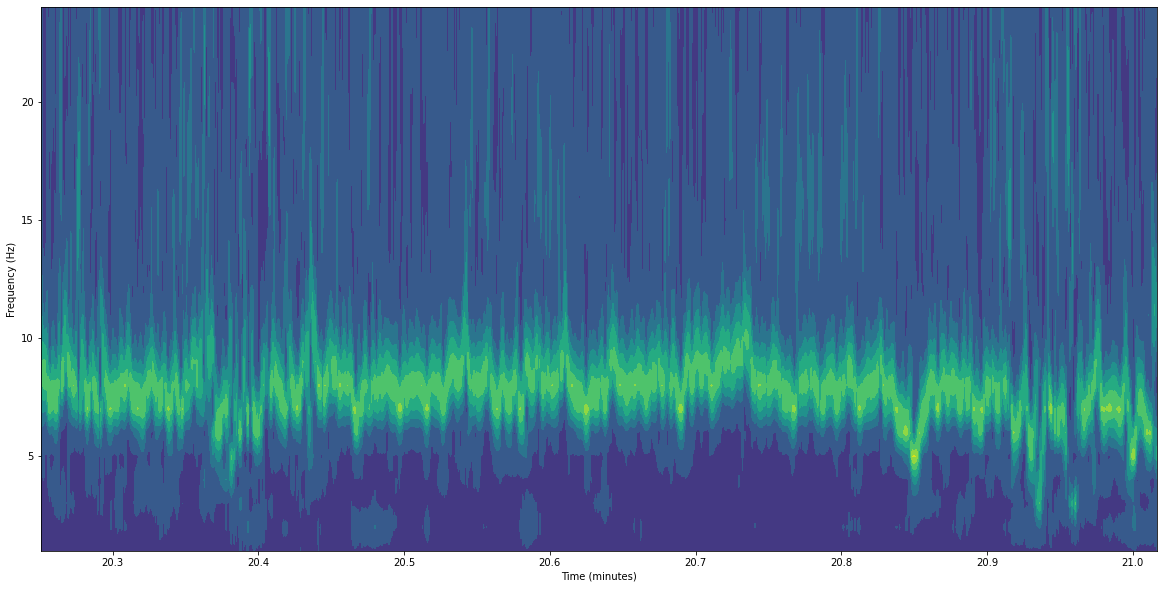

In [ ]:
#@title Plotting the time frequency graph
plt.gcf().set_size_inches(20, 10)
plt.contourf(t1,frequency[1:25],tf[0:24])
plt.xlabel(r'Time (minutes)')
plt.ylabel(r'Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

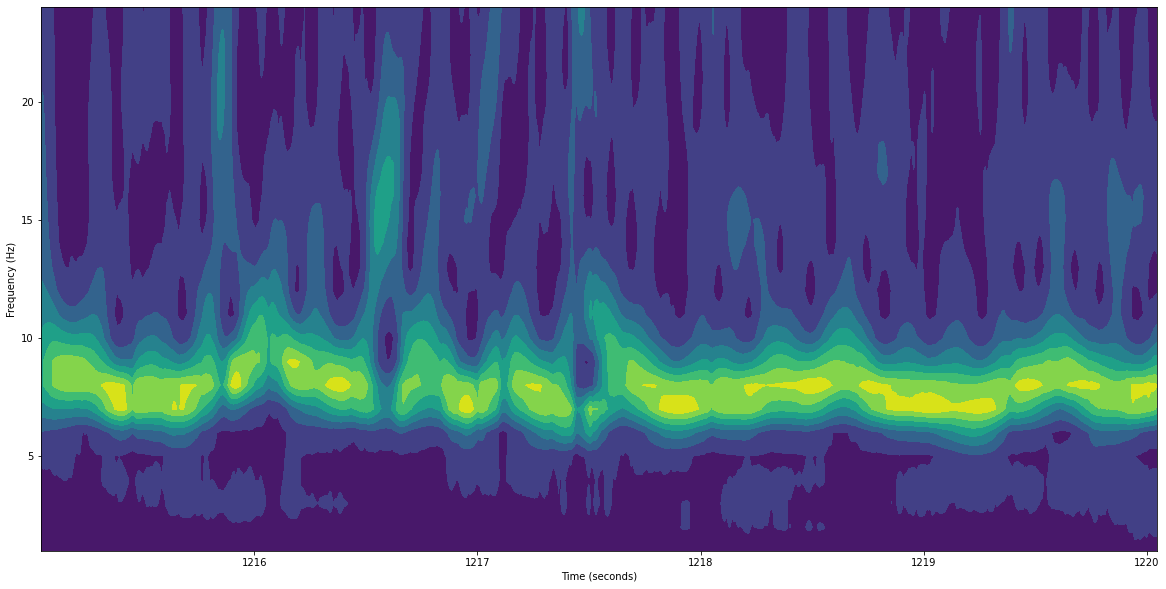

In [ ]:
#@title Plotting the time frequency graph of the first 10 seconds
plt.gcf().set_size_inches(20, 10)
plt.contourf(t1[0:12500]*60,frequency[1:25],tf[0:24,0:12500])
plt.xlabel(r'Time (seconds)')
plt.ylabel(r'Frequency (Hz)')

# Empirical mode decomposition
- REM signals require a certain level of pretreatment in order to extract the theta signals, and detect the cycles and their respective timestamps
- The timestamps are then run through certain threshold checks and those that satisfy the threshold are used to capture spectral information within those time stamp envelopes
- Definition of the  Empirical Mode Decomposition (EMD) function from the ```emd``` library. Occasionally the EMD can be reffered to here as a sift.

<Axes: xlabel='Time (samples)'>

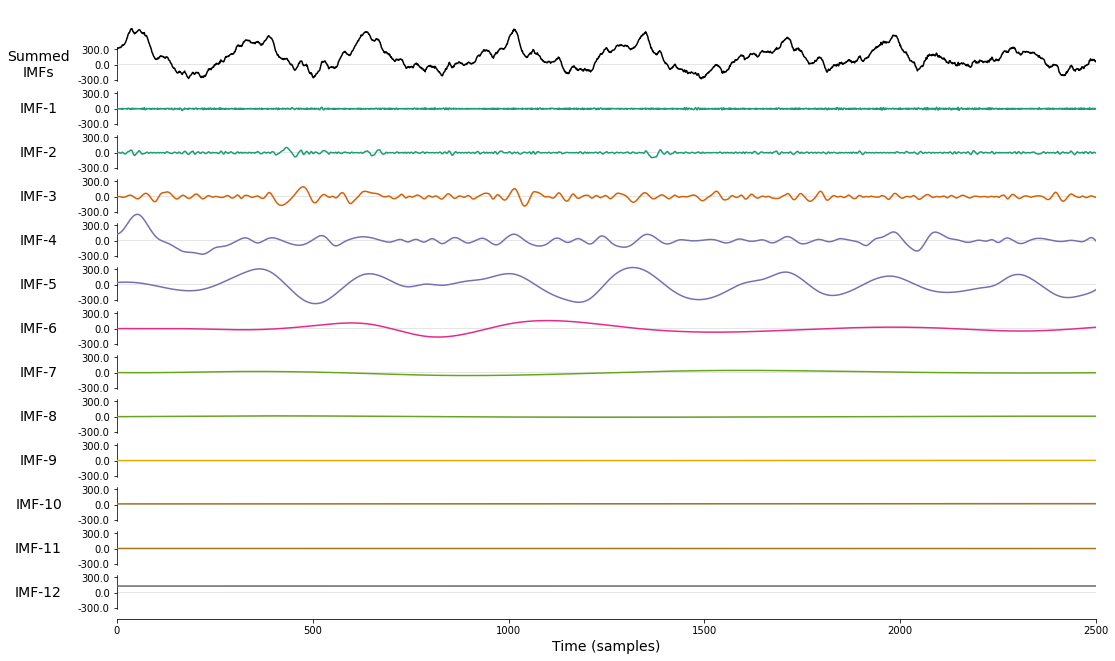

In [ ]:
#@title Signal decomposition using regular sift
sift=emd.sift.sift(REM[0])
emd.plotting.plot_imfs(sift[:2500,:])

#### Definition of the mean frequencies function
- The function below is a simple calculation of the parameters required to determine the mean frequency of the signal.
-```meanfreq``` is a variable that contains the frequencies of the imfs
-Boolean conditions are introduced to split the imfs into three different signals. Subtheta (below theta), theta, and supratheta (above theta which includes gamma)

In [ ]:
def meanfreqsum(x,smprate,thetarange):
    imf=np.transpose(x)
    lower=np.min(thetarange)
    upper=np.max(thetarange)
    analytic_signal = scipy.signal.hilbert(imf)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * smprate)
    meanfreq= np.mean(instantaneous_frequency,axis=1)
    sub_range=np.where(meanfreq<lower)
    theta_range=np.logical_and(meanfreq>=lower,meanfreq<upper)
    supra_range=np.where(meanfreq<lower)
    theta_lfp = np.sum(imf[np.where(theta_range)[0]],axis=0)
    supratheta_lfp=np.sum(imf[np.where(meanfreq>upper)[0]],axis=0)
    subtheta_lfp=np.sum(imf[np.where(meanfreq<lower)[0]],axis=0)
    return subtheta_lfp,theta_lfp,supratheta_lfp,meanfreq,[sub_range,theta_range,supra_range]

### Definition of the Frequency Filter function

- Here is another way to split frequencies into their respective bands.
- This function utilises some of the output parameters given on request on masked sift functions such as ```emd.sift.mask_sift()``` and ```emd.sift.iterated_mask_sift()```, using ``` ret_mask_freq=True```

In [ ]:
def freqfilter(imf,smprate,freqrange=(5,12)): #Requires Warning prompts
  mask_freq=imf[1]*smprate
  maskimf=np.transpose(imf[0])
  lower=np.min(freqrange)
  upper=np.max(freqrange)
  maskindex=np.where(np.logical_and(mask_freq>=lower,mask_freq<upper))
  submaskindex=np.where(mask_freq<lower)
  supramaskindex=np.where(mask_freq>upper)
  sub=np.sum(maskimf[submaskindex],axis=0)
  theta=np.sum(maskimf[maskindex],axis=0)
  supra=np.sum(maskimf[supramaskindex],axis=0)
  return sub,theta,supra,mask_freq,[submaskindex,maskindex,supramaskindex]

- The output provides a tuple.
- Both ```freqfilter()``` and the ```meanfreqsum()``` is nested within the ```siftextract()``` function.
- This function detects the IMF function shape whether it's a tuple or an array and depending on the case will appropiately split the IMFs into their respective frequency bands.

In [ ]:
def siftextract(imf,smprate,freqrange=(5,12)):
  if isinstance(imf,tuple):
    maskimf=freqfilter(imf,smprate,freqrange)
  else:
    maskimf=meanfreqsum(imf,smprate,freqrange)
  return maskimf

Normal Sift
Ensemble Sift
Complete Ensemble Sift
Masked Sift Zero Cross Setting
Masked Sift Instantaneous Frequency Setting
Iterated Masked Sift Zero Cross Setting


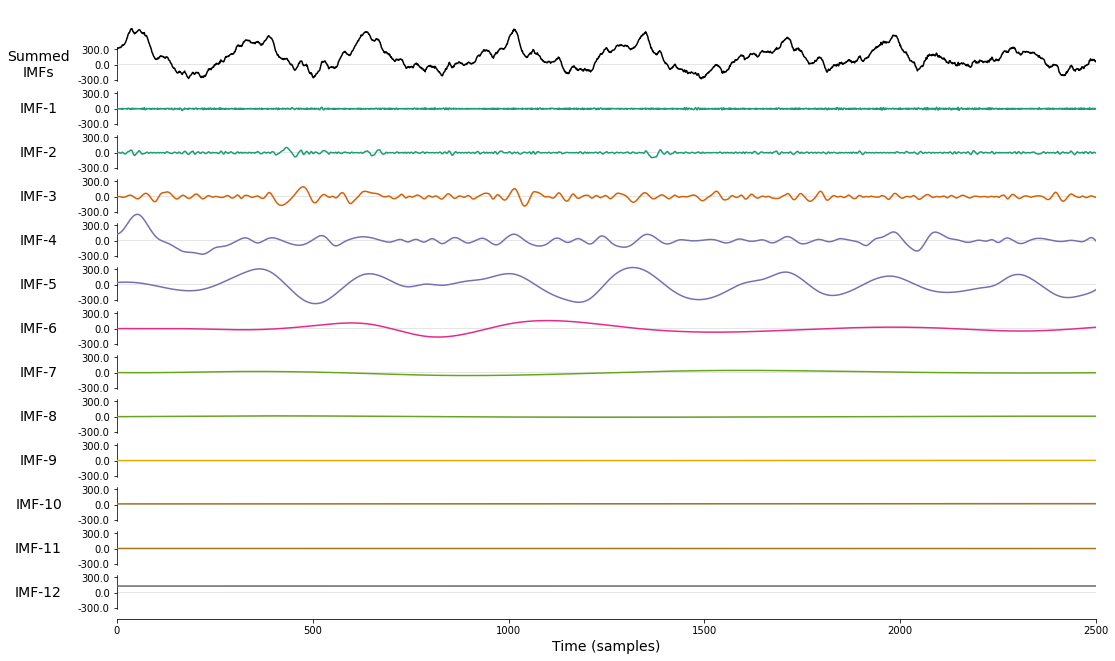

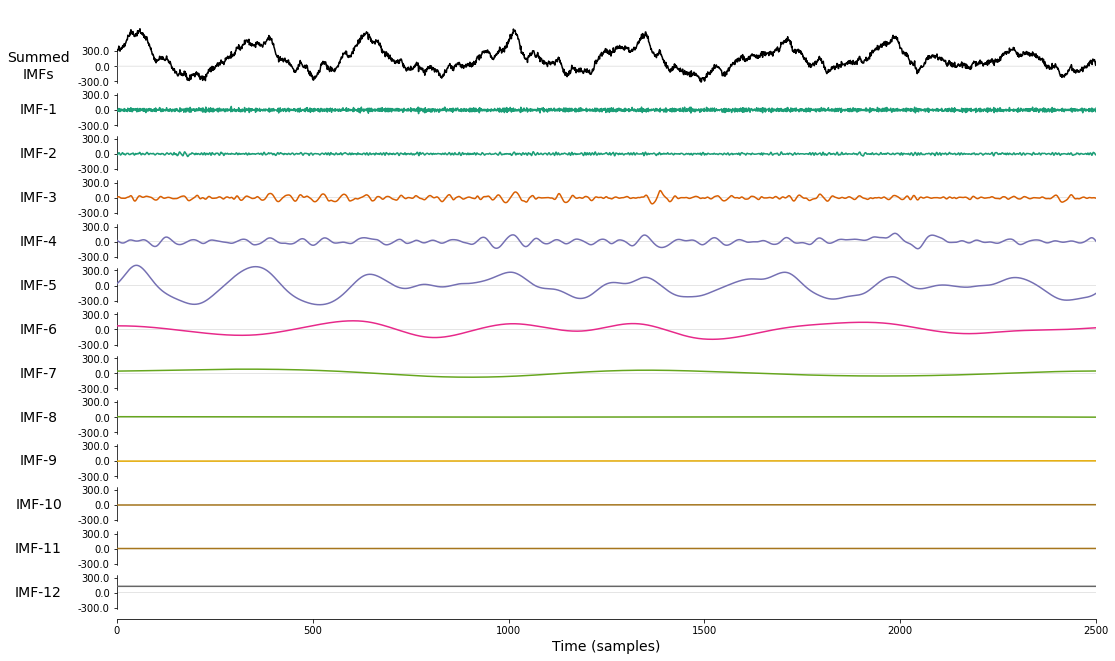

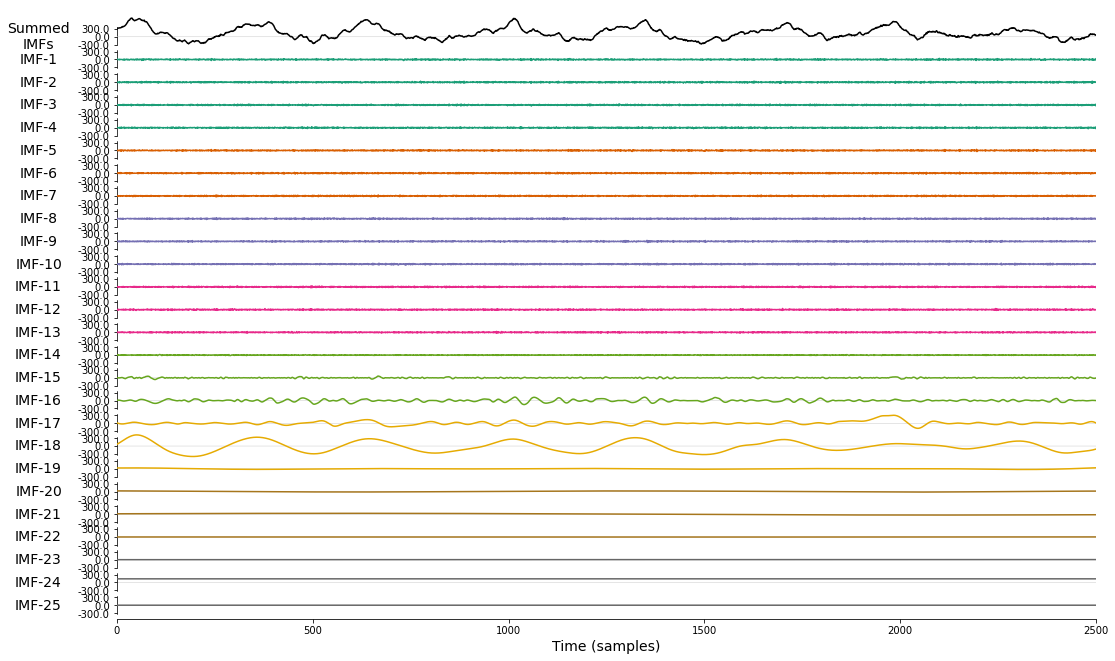

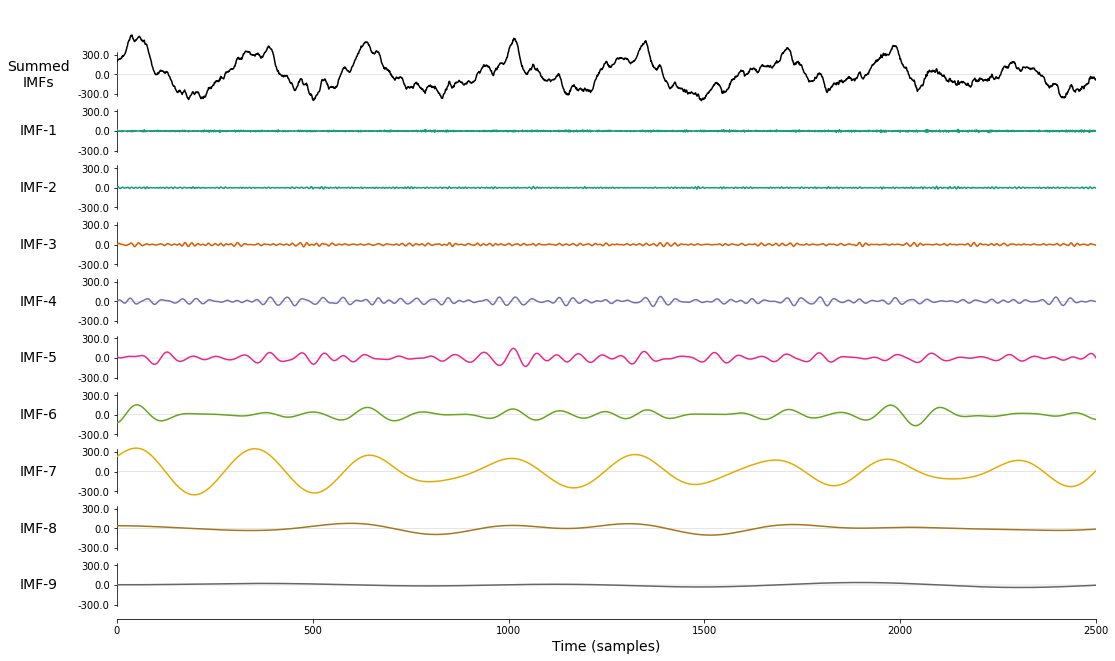

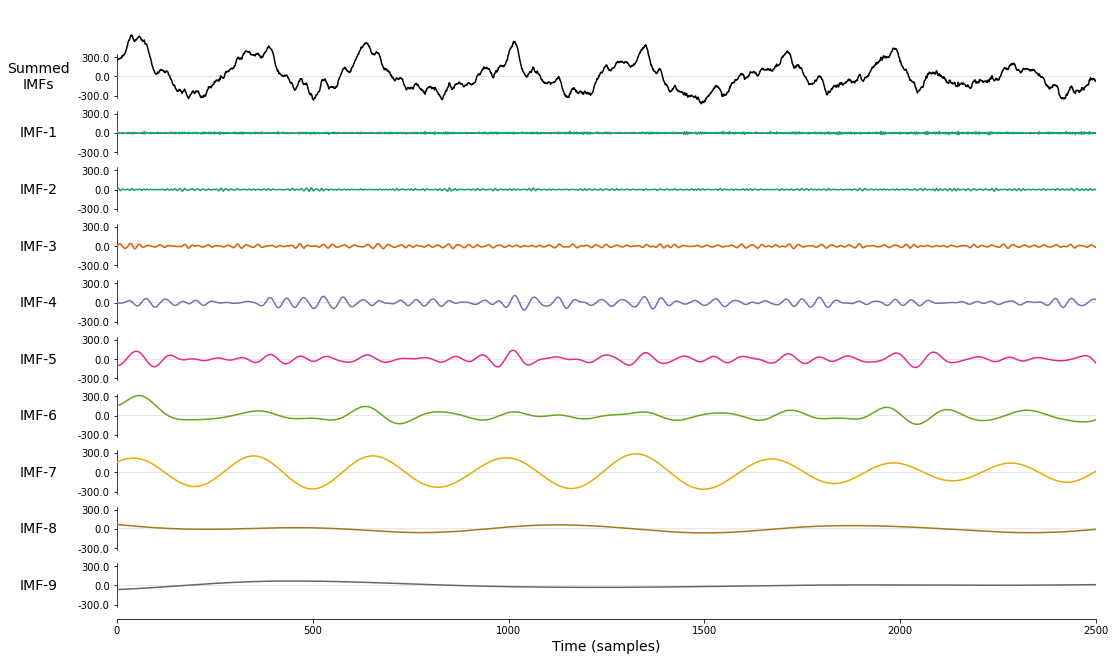

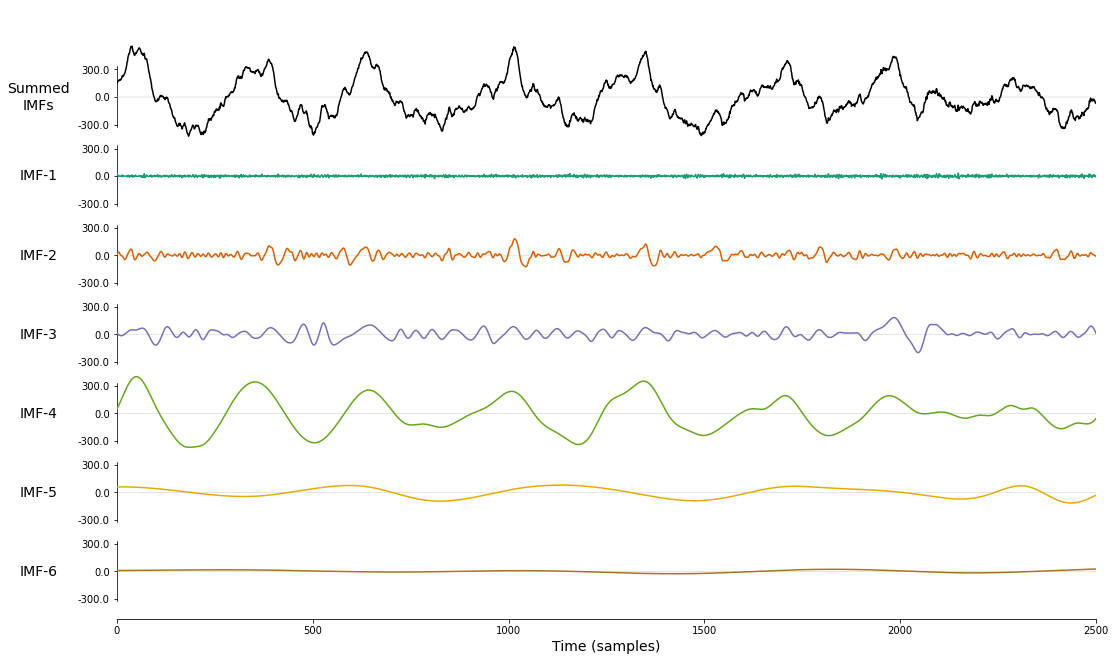

In [ ]:
#@title IMF Figure plots of different sift methods
print('Normal Sift')
sift=emd.sift.sift(REM[0])
thetaplot=siftextract(sift,2500,(5,12))
siftft=emd.spectra.frequency_transform(sift,2500,'nht')
siftfig=emd.plotting.plot_imfs(sift[:2500,:]).get_figure()
#########
print('Ensemble Sift')
ensemble=emd.sift.ensemble_sift(REM[0])
thetaplot2=siftextract(ensemble,2500,(5,12))
ensembleft=emd.spectra.frequency_transform(ensemble,2500,'nht')
ensemblefig=emd.plotting.plot_imfs(ensemble[:2500,:]).get_figure()
##########
print('Complete Ensemble Sift')
censemble,noise=emd.sift.complete_ensemble_sift(REM[0])
thetaplot3=siftextract(censemble,2500,(5,12))
censembleft=emd.spectra.frequency_transform(censemble,2500,'nht')
censemblefig=emd.plotting.plot_imfs(censemble[:2500,:]).get_figure()
##########
print('Masked Sift Zero Cross Setting')
maskzc=emd.sift.mask_sift(REM[0],mask_freqs='zc',ret_mask_freq='True')
thetaplot4=siftextract(maskzc,2500,(5,12))
maskzcft=emd.spectra.frequency_transform(maskzc[0],2500,'nht')
maskzcfig=emd.plotting.plot_imfs(maskzc[0][:2500,:]).get_figure()
##########
print('Masked Sift Instantaneous Frequency Setting')
maskif=emd.sift.mask_sift(REM[0],mask_freqs='if',ret_mask_freq='True')
thetaplot5=siftextract(maskif,2500,(5,12))
maskifft=emd.spectra.frequency_transform(maskif[0],2500,'nht')
maskiffig=emd.plotting.plot_imfs(maskif[0][:2500,:]).get_figure()
#########
print('Iterated Masked Sift Zero Cross Setting')
imask=emd.sift.iterated_mask_sift(REM[0],mask_0='zc',ret_mask_freq='True')
thetaplot6=siftextract(imask,2500,(5,12))
imaskft=emd.spectra.frequency_transform(imask[0],2500,'nht')
imaskzcfig=emd.plotting.plot_imfs(imask[0][:2500,:]).get_figure()
######Figure Plots#####
# imaskiffig=emd.plotting.plot_imfs(imaskif[0][:2500,:]).get_figure()
# imaskrandfig=emd.plotting.plot_imfs(imaskrand[0][:2500,:]).get_figure()
# imask9fig=emd.plotting.plot_imfs(imask9[0][:2500,:]).get_figure()

Text(0.5, 1.0, 'Complete Ensemble Sift')

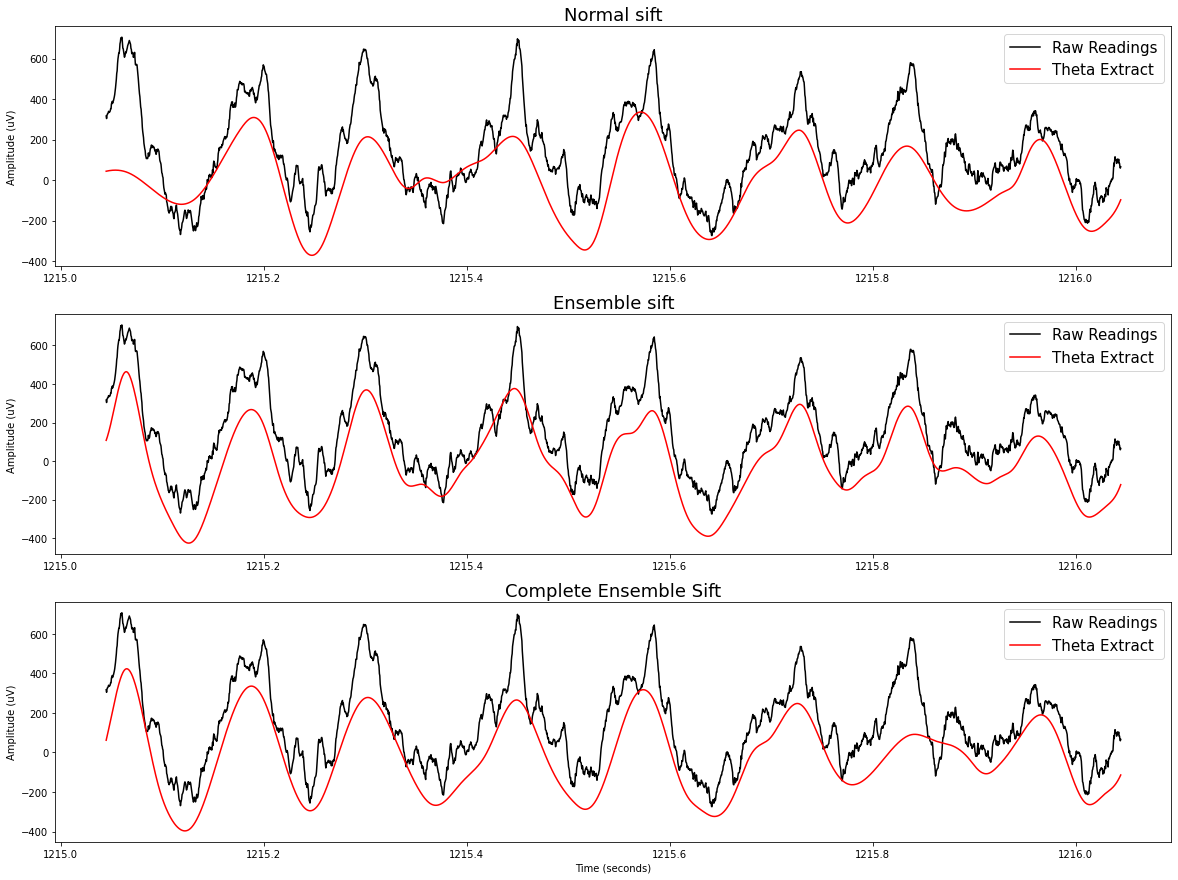

In [ ]:
#@title Raw signal vs. Sift Method Theta Signal
#@markdown Normal Sift, Ensemble Sift, and Complete Ensemble Sift

ts2=sleep_trans/2500
seconds=np.linspace(ts2[0][0],ts2[0][1],tf.shape[1])
fig1,ax1=plt.subplots(3,figsize=(20,15))
plt.rcParams.update({'font.size': 15})
##### Normal Sift
ax1[0].plot(seconds[0:2500],REM[0][0:2500],'-k',label='Raw Readings')
ax1[0].plot(seconds[0:2500],thetaplot[1][0:2500],'-r',label='Theta Extract')
ax1[0].legend(loc="upper right")
ax1[0].set_ylabel(r'Amplitude (uV)')
ax1[0].set_title('Normal sift')
##### Ensemble Sift
ax1[1].plot(seconds[0:2500],REM[0][0:2500],'-k',label='Raw Readings')
ax1[1].plot(seconds[0:2500],thetaplot2[1][0:2500],'-r',label='Theta Extract')
ax1[1].legend(loc="upper right")
ax1[1].set_ylabel(r'Amplitude (uV)')
ax1[1].set_title('Ensemble sift')
#### Complete Ensemble Sift
ax1[2].plot(seconds[0:2500],REM[0][0:2500],'-k',label='Raw Readings')
ax1[2].plot(seconds[0:2500],thetaplot3[1][0:2500],'-r',label='Theta Extract')
ax1[2].legend(loc="upper right")
ax1[2].set_ylabel(r'Amplitude (uV)')
ax1[2].set_xlabel(r'Time (seconds)')
ax1[2].set_title(r'Complete Ensemble Sift')

Text(0.5, 1.0, 'Iterated Masked Sift')

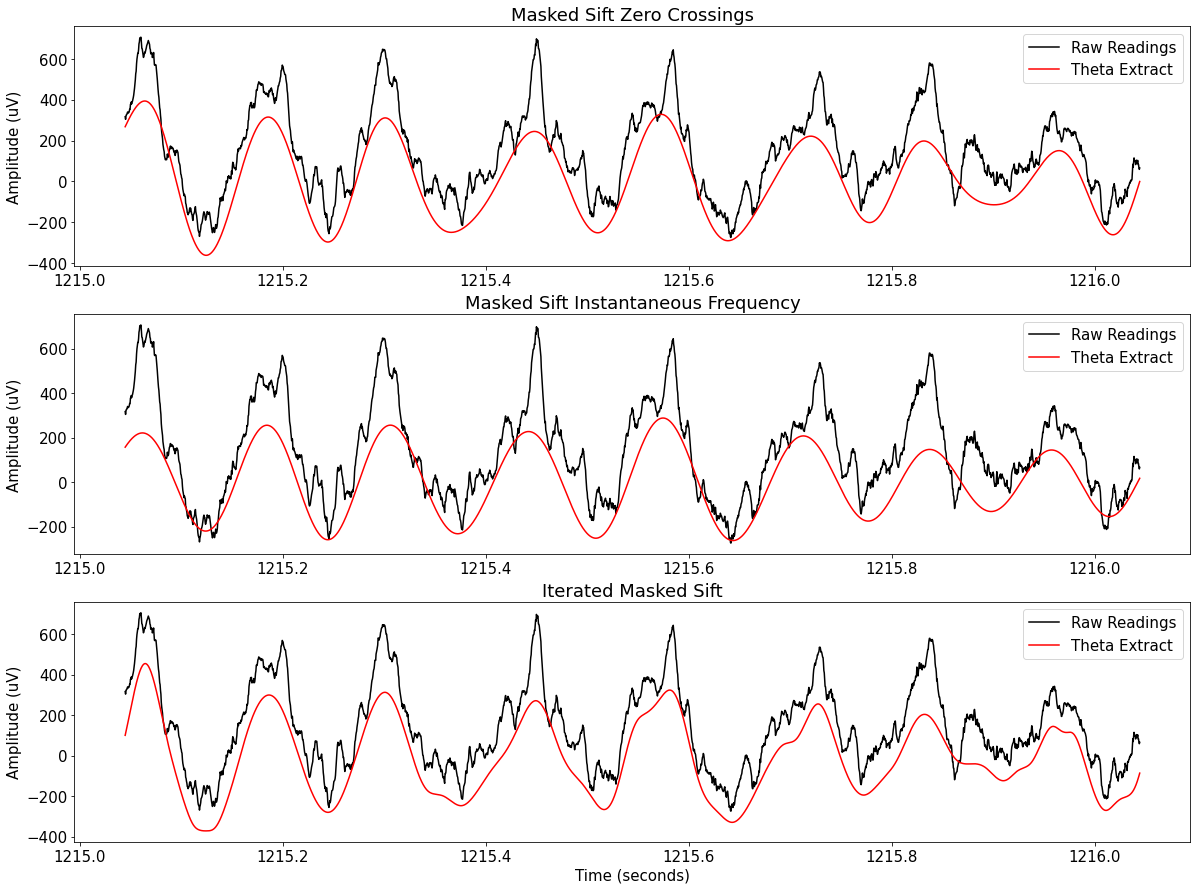

In [ ]:
#@markdown Masked Sift Zero Crossings, Masked Sift Instantaneous Frequency, and Iterated Mask Sift Zero Crossings Sift

fig2,ax2=plt.subplots(3,figsize=(20,15))
plt.rcParams.update({'font.size': 15})
##### Normal Sift
ax2[0].plot(seconds[0:2500],REM[0][0:2500],'-k',label='Raw Readings')
ax2[0].plot(seconds[0:2500],thetaplot4[1][0:2500],'-r',label='Theta Extract')
ax2[0].legend(loc="upper right")
ax2[0].set_ylabel(r'Amplitude (uV)')
ax2[0].set_title('Masked Sift Zero Crossings')
##### Ensemble Sift
ax2[1].plot(seconds[0:2500],REM[0][0:2500],'-k',label='Raw Readings')
ax2[1].plot(seconds[0:2500],thetaplot5[1][0:2500],'-r',label='Theta Extract')
ax2[1].legend(loc="upper right")
ax2[1].set_ylabel(r'Amplitude (uV)')
ax2[1].set_title('Masked Sift Instantaneous Frequency')
#### Complete Ensemble Sift
ax2[2].plot(seconds[0:2500],REM[0][0:2500],'-k',label='Raw Readings')
ax2[2].plot(seconds[0:2500],thetaplot6[1][0:2500],'-r',label='Theta Extract')
ax2[2].legend(loc="upper right")
ax2[2].set_ylabel(r'Amplitude (uV)')
ax2[2].set_xlabel(r'Time (seconds)')
ax2[2].set_title(r'Iterated Masked Sift')

In [ ]:
# def freqtransform(imf,smprate):
#   IA = scipy.signal.hilbert(imf)
#   instantaneous_phase = np.unwrap(np.angle(IA))
#   IP= np.unwrap(np.angle(IA,deg=True))
#   IP=IP%360
#   IF = (np.diff(instantaneous_phase) /(2.0*np.pi) * smprate)
#   return IP,IF,IA

In [ ]:
# #### Normal Sift
# # sifttheta=freqtransform(thetaplot[1],2500)
# # siftgamma=freqtransform(thetaplot[2],2500)
# sifttheta=phaseconvert(emd.spectra.frequency_transform(thetaplot[1],2500,'nht'))
# siftgamma=phaseconvert(emd.spectra.frequency_transform(thetaplot[2],2500,'nht'))
# #### Ensemble sift
# # ensembletheta=freqtransform(thetaplot2[1],2500)
# # ensemblegamma=freqtransform(thetaplot2[2],2500)
# ensembletheta=phaseconvert(emd.spectra.frequency_transform(thetaplot2[1],2500,'nht'))
# ensemblegamma=phaseconvert(emd.spectra.frequency_transform(thetaplot2[2],2500,'nht'))
# #### Complete Ensemble Sift
# # censembletheta=freqtransform(thetaplot3[1],2500)
# # censemblegamma=freqtransform(thetaplot3[2],2500)
# censembletheta=phaseconvert(emd.spectra.frequency_transform(thetaplot3[1],2500,'nht'))
# censemblegamma=phaseconvert(emd.spectra.frequency_transform(thetaplot3[2],2500,'nht'))
# #### Mask Sift Zero crossings
# # maskzctheta=freqtransform(thetaplot4[1],2500)
# # maskzcgamma=freqtransform(thetaplot4[2],2500)
# maskzctheta=phaseconvert(emd.spectra.frequency_transform(thetaplot4[1],2500,'nht'))
# maskzcgamma=phaseconvert(emd.spectra.frequency_transform(thetaplot4[2],2500,'nht'))
# #### Mask Sift Instantaneous Frequency
# # maskiftheta=freqtransform(thetaplot5[1],2500)
# # maskifgamma=freqtransform(thetaplot5[2],2500)
# maskiftheta=phaseconvert(emd.spectra.frequency_transform(thetaplot5[1],2500,'nht'))
# maskifgamma=phaseconvert(emd.spectra.frequency_transform(thetaplot5[2],2500,'nht'))
# #### Iterated Mask
# # imasktheta=freqtransform(thetaplot6[1],2500)
# # imaskgamma=freqtransform(thetaplot6[2],2500)
# imasktheta=phaseconvert(emd.spectra.frequency_transform(thetaplot6[1],2500,'nht'))
# imaskgamma=phaseconvert(emd.spectra.frequency_transform(thetaplot6[2],2500,'nht'))

### ★ Redefining the theta-gamma split function

In [ ]:
def tgsplit(x,smprate,freqrange=(5,12)):
  lower=np.min(freqrange)
  upper=np.max(freqrange)
  if isinstance(x, tuple):
    imf=np.transpose(x[0])
    mask_freq=x[1]*smprate
  else:
    imf=np.transpose(x)
    analytic_signal = scipy.signal.hilbert(imf)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) /(2.0*np.pi) * smprate)
    mask_freq= np.mean(instantaneous_frequency,axis=1)
  maskindex=np.logical_and(mask_freq>=lower,mask_freq<upper)
  submaskindex=mask_freq<lower
  supramaskindex=mask_freq>upper
  sub=[submaskindex]
  theta=[maskindex]
  supra=[supramaskindex]
  return sub,theta,supra

## Amplitude and Frequency Histograms of all possible sifting Modes

Text(0.5, 0, 'Amplitude (uV)')

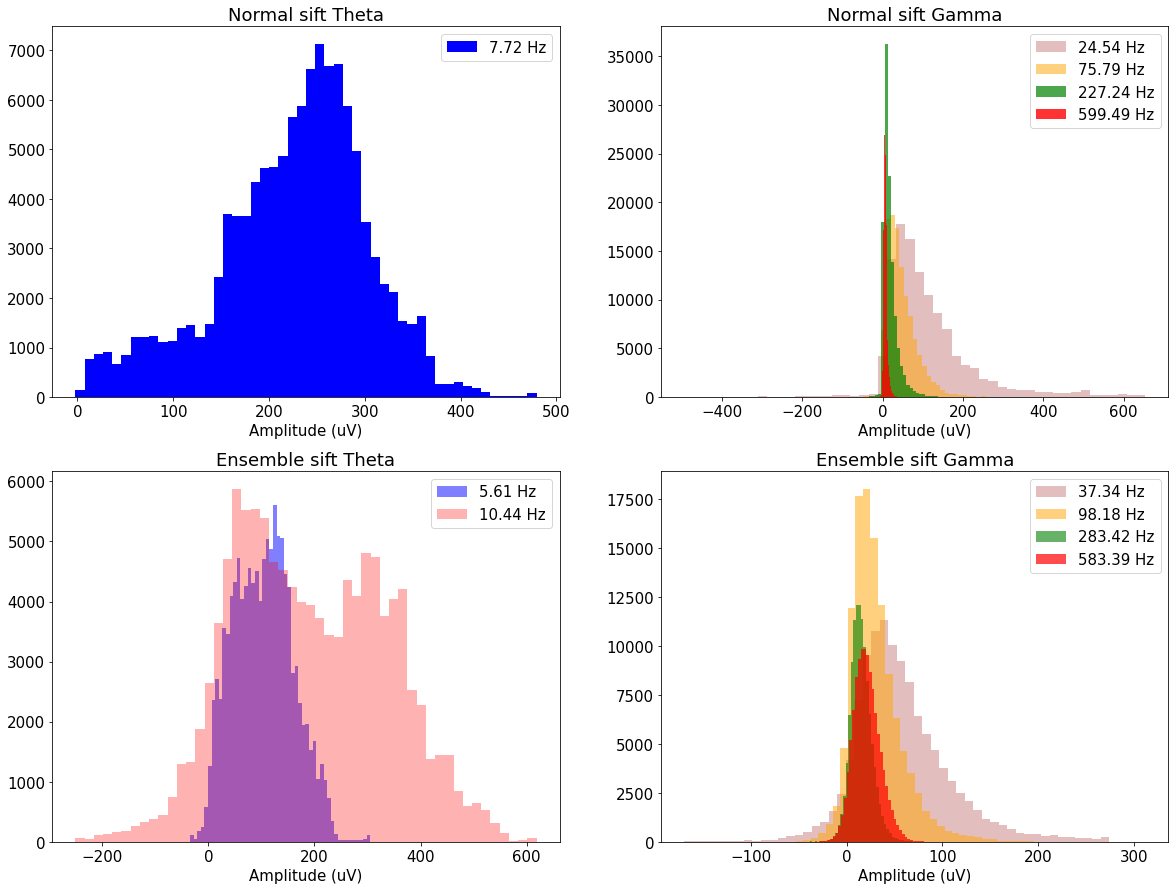

In [ ]:
#@title Normal and Ensemble sift Histograms
siftsplit=tgsplit(sift,2500)
ensemblesplit=tgsplit(ensemble,2500)
censemblesplit=tgsplit(censemble,2500)
maskzcsplit=tgsplit(maskzc,2500)
maskifsplit=tgsplit(maskif,2500,(4,12))
imasksplit=tgsplit(imask,2500)

fig7,ax7=plt.subplots(2,2,figsize=(20,15))
plt.rcParams.update({'font.size': 15})
## Sift Mask
ax7[0,0].hist(siftft[2][:,siftsplit[1][0]],bins=50,edgecolor='none',color='blue',label=str(np.round((np.mean(siftft[1][:,siftsplit[1][0]])),2))+' Hz')
ax7[0,0].legend(loc="upper right")
ax7[0,1].hist(siftft[2][:,siftsplit[2][0]][:,3],bins=50,alpha=0.3,edgecolor='none',color='brown',label=str(np.round(np.mean(siftft[1][:,siftsplit[2][0]],axis=0)[3],2))+' Hz')
ax7[0,1].hist(siftft[2][:,siftsplit[2][0]][:,2],bins=50,alpha=0.5,edgecolor='none',color='orange',label=str(np.round(np.mean(siftft[1][:,siftsplit[2][0]],axis=0)[2],2))+' Hz')
ax7[0,1].hist(siftft[2][:,siftsplit[2][0]][:,1],bins=50,alpha=0.7,edgecolor='none',color='green',label=str(np.round(np.mean(siftft[1][:,siftsplit[2][0]],axis=0)[1],2))+' Hz')
ax7[0,1].hist(siftft[2][:,siftsplit[2][0]][:,0],bins=50,alpha=0.8,edgecolor='none',color='red',label=str(np.round(np.mean(siftft[1][:,siftsplit[2][0]],axis=0)[0],2))+' Hz')
ax7[0,1].legend(loc="upper right")
ax7[0,0].set_title('Normal sift Theta')
ax7[0,1].set_title('Normal sift Gamma')
ax7[0,0].set_xlabel(r'Amplitude (uV)')
ax7[0,1].set_xlabel(r'Amplitude (uV)')
## Ensemble Sift
ax7[1,0].hist(ensembleft[2][:,ensemblesplit[1][0]][:,1],bins=50,edgecolor='none',alpha=0.5,color='blue',label=str(np.round(np.mean(ensembleft[1][:,ensemblesplit[1][0]],axis=0)[1],2))+' Hz')
ax7[1,0].hist(ensembleft[2][:,ensemblesplit[1][0]][:,0],bins=50,alpha=0.3,color='red',label=str(np.round(np.mean(ensembleft[1][:,ensemblesplit[1][0]],axis=0)[0],2))+' Hz')
ax7[1,0].legend(loc="upper right")
ax7[1,1].hist(ensembleft[2][:,ensemblesplit[2][0]][:,3],bins=50,edgecolor='none',alpha=0.3,color='brown',label=str(np.round(np.mean(ensembleft[1][:,ensemblesplit[2][0]],axis=0)[3],2))+' Hz')
ax7[1,1].hist(ensembleft[2][:,ensemblesplit[2][0]][:,2],bins=50,edgecolor='none',alpha=0.5,color='orange',label=str(np.round(np.mean(ensembleft[1][:,ensemblesplit[2][0]],axis=0)[2],2))+' Hz')
ax7[1,1].hist(ensembleft[2][:,ensemblesplit[2][0]][:,1],bins=50,edgecolor='none',alpha=0.6,color='green',label=str(np.round(np.mean(ensembleft[1][:,ensemblesplit[2][0]],axis=0)[1],2))+' Hz')
ax7[1,1].hist(ensembleft[2][:,ensemblesplit[2][0]][:,0],bins=50,edgecolor='none',alpha=0.7,color='red',label=str(np.round(np.mean(ensembleft[1][:,ensemblesplit[2][0]],axis=0)[0],2))+' Hz')
ax7[1,1].legend(loc="upper right")
ax7[1,0].set_title('Ensemble sift Theta')
ax7[1,1].set_title('Ensemble sift Gamma')
ax7[1,0].set_xlabel(r'Amplitude (uV)')
ax7[1,1].set_xlabel(r'Amplitude (uV)')

<ipython-input-22-3b4d2c717692>:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax8[0,0].hist(maskzcft[2][:,maskzcsplit[1][0]][:,1],bins=50,edgecolor='none',alpha=0.5,color='blue',label=str(np.round(maskzc[1][maskzcsplit[1]][1]*2500,2))+' Hz')
<ipython-input-22-3b4d2c717692>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax8[0,0].hist(maskzcft[2][:,maskzcsplit[1][0]][:,0],bins=50,alpha=0.3,color='red',label=str(np.round(maskzc[1][maskzcsplit[1]][0]*2500,2))+' Hz')
<ipython-input-22-3b4d2c717692>:8: FutureWarning: Using a non-tuple sequ

Text(0.5, 0, 'Amplitude (uV)')

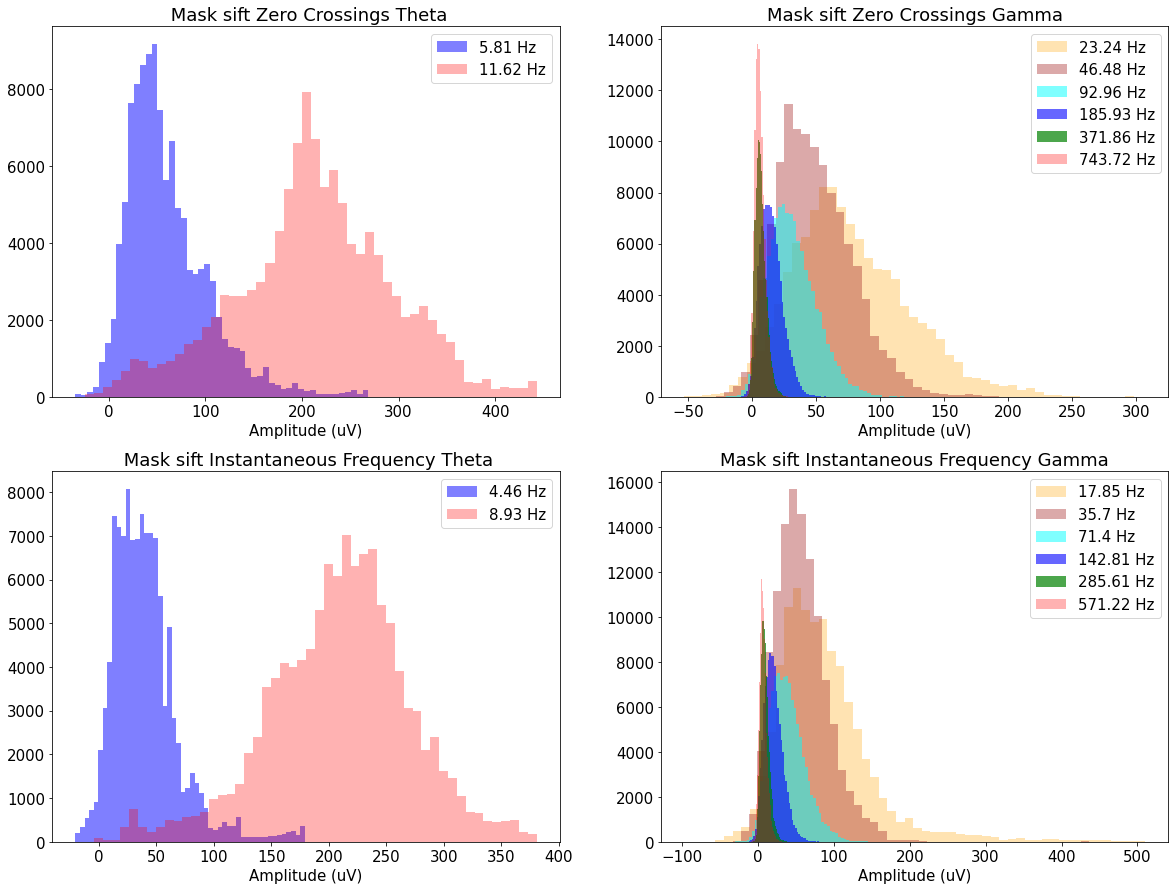

In [ ]:
#@title Masked Sift  (Zero Crossings and Instantaneous Frequency) Histograms
fig8,ax8=plt.subplots(2,2,figsize=(20,15))
plt.rcParams.update({'font.size': 15})
## Mask Sift Zero Crossings
ax8[0,0].hist(maskzcft[2][:,maskzcsplit[1][0]][:,1],bins=50,edgecolor='none',alpha=0.5,color='blue',label=str(np.round(maskzc[1][maskzcsplit[1]][1]*2500,2))+' Hz')
ax8[0,0].hist(maskzcft[2][:,maskzcsplit[1][0]][:,0],bins=50,alpha=0.3,color='red',label=str(np.round(maskzc[1][maskzcsplit[1]][0]*2500,2))+' Hz')
ax8[0,0].legend(loc="upper right")
ax8[0,1].hist(maskzcft[2][:,maskzcsplit[2][0]][:,5],bins=50,edgecolor='none',alpha=0.3,color='orange',label=str(np.round(maskzc[1][maskzcsplit[2]][5]*2500,2))+' Hz')
ax8[0,1].hist(maskzcft[2][:,maskzcsplit[2][0]][:,4],bins=50,edgecolor='none',alpha=0.4,color='brown',label=str(np.round(maskzc[1][maskzcsplit[2]][4]*2500,2))+' Hz')
ax8[0,1].hist(maskzcft[2][:,maskzcsplit[2][0]][:,3],bins=50,edgecolor='none',alpha=0.5,color='cyan',label=str(np.round(maskzc[1][maskzcsplit[2]][3]*2500,2))+' Hz')
ax8[0,1].hist(maskzcft[2][:,maskzcsplit[2][0]][:,2],bins=50,edgecolor='none',alpha=0.6,color='blue',label=str(np.round(maskzc[1][maskzcsplit[2]][2]*2500,2))+' Hz')
ax8[0,1].hist(maskzcft[2][:,maskzcsplit[2][0]][:,1],bins=50,edgecolor='none',alpha=0.7,color='green',label=str(np.round(maskzc[1][maskzcsplit[2]][1]*2500,2))+' Hz')
ax8[0,1].hist(maskzcft[2][:,maskzcsplit[2][0]][:,0],bins=50,edgecolor='none',alpha=0.3,color='red',label=str(np.round(maskzc[1][maskzcsplit[2]][0]*2500,2))+' Hz')
ax8[0,1].legend(loc="upper right")
ax8[0,0].set_title(' Mask sift Zero Crossings Theta')
ax8[0,1].set_title('Mask sift Zero Crossings Gamma')
ax8[0,0].set_xlabel(r'Amplitude (uV)')
ax8[0,1].set_xlabel(r'Amplitude (uV)')
## Mask Sift Instantaneous Frequency
ax8[1,0].hist(maskifft[2][:,maskifsplit[1][0]][:,1],bins=50,edgecolor='none',alpha=0.5,color='blue',label=str(np.round(maskif[1][maskifsplit[1]][1]*2500,2))+' Hz')
ax8[1,0].hist(maskifft[2][:,maskifsplit[1][0]][:,0],bins=50,alpha=0.3,color='red',label=str(np.round(maskif[1][maskifsplit[1]][0]*2500,2))+' Hz')
ax8[1,0].legend(loc="upper right")
ax8[1,1].hist(maskifft[2][:,maskifsplit[2][0]][:,5],bins=50,edgecolor='none',alpha=0.3,color='orange',label=str(np.round(maskif[1][maskifsplit[2]][5]*2500,2))+' Hz')
ax8[1,1].hist(maskifft[2][:,maskifsplit[2][0]][:,4],bins=50,edgecolor='none',alpha=0.4,color='brown',label=str(np.round(maskif[1][maskifsplit[2]][4]*2500,2))+' Hz')
ax8[1,1].hist(maskifft[2][:,maskifsplit[2][0]][:,3],bins=50,edgecolor='none',alpha=0.5,color='cyan',label=str(np.round(maskif[1][maskifsplit[2]][3]*2500,2))+' Hz')
ax8[1,1].hist(maskifft[2][:,maskifsplit[2][0]][:,2],bins=50,edgecolor='none',alpha=0.6,color='blue',label=str(np.round(maskif[1][maskifsplit[2]][2]*2500,2))+' Hz')
ax8[1,1].hist(maskifft[2][:,maskifsplit[2][0]][:,1],bins=50,edgecolor='none',alpha=0.7,color='green',label=str(np.round(maskif[1][maskifsplit[2]][1]*2500,2))+' Hz')
ax8[1,1].hist(maskifft[2][:,maskifsplit[2][0]][:,0],bins=50,edgecolor='none',alpha=0.3,color='red',label=str(np.round(maskif[1][maskifsplit[2]][0]*2500,2))+' Hz')
ax8[1,1].legend(loc="upper right")
ax8[1,0].set_title(' Mask sift Instantaneous Frequency Theta')
ax8[1,1].set_title('Mask sift Instantaneous Frequency Gamma')
ax8[1,0].set_xlabel(r'Amplitude (uV)')
ax8[1,1].set_xlabel(r'Amplitude (uV)')

<ipython-input-23-e813ab9e322a>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax9[0,0].hist(imaskft[2][:,imasksplit[1][0]][:,1],bins=50,edgecolor='none',alpha=0.5,color='blue',label=str(np.round(imask[1][imasksplit[1]][1]*2500,2))+' Hz')
<ipython-input-23-e813ab9e322a>:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax9[0,0].hist(imaskft[2][:,imasksplit[1][0]][:,0],bins=50,edgecolor='none',alpha=0.3,color='red',label=str(np.round(imask[1][imasksplit[1]][0]*2500,2))+' Hz')
<ipython-input-23-e813ab9e322a>:14: FutureWarning: Using a no

Text(0.5, 0, 'Amplitude (uV)')

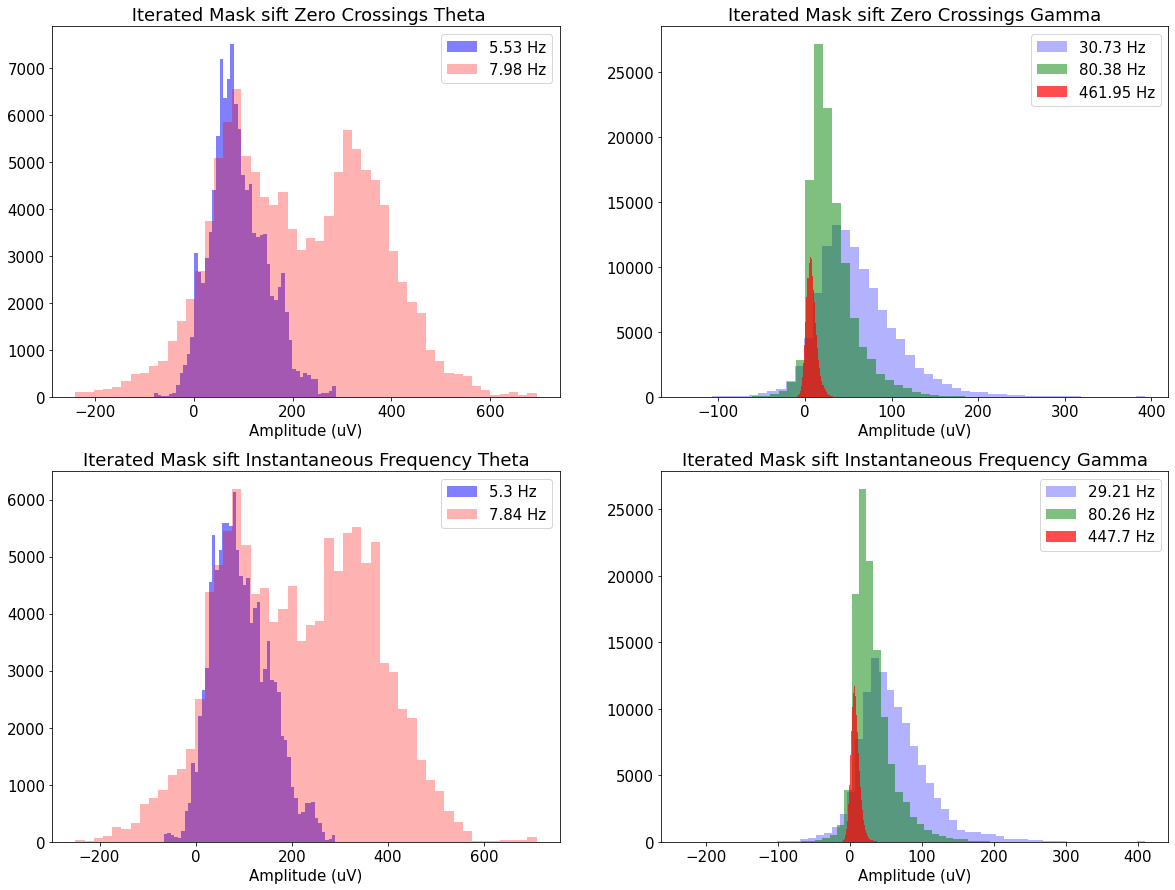

In [ ]:
#@title Iterated Mask Sift (Zero Crossings and Instantaneous Frequency) Histograms

imaskif=emd.sift.iterated_mask_sift(REM[0],mask_0='if',ret_mask_freq='True')
imaskifft=emd.spectra.frequency_transform(imaskif[0],2500,'nht')
imaskifsplit=tgsplit(imaskif,2500)


fig9,ax9=plt.subplots(2,2,figsize=(20,15))
plt.rcParams.update({'font.size': 15})
## Iterated Mask Sift Zero Crossings
ax9[0,0].hist(imaskft[2][:,imasksplit[1][0]][:,1],bins=50,edgecolor='none',alpha=0.5,color='blue',label=str(np.round(imask[1][imasksplit[1]][1]*2500,2))+' Hz')
ax9[0,0].hist(imaskft[2][:,imasksplit[1][0]][:,0],bins=50,edgecolor='none',alpha=0.3,color='red',label=str(np.round(imask[1][imasksplit[1]][0]*2500,2))+' Hz')
ax9[0,0].legend(loc="upper right")
ax9[0,1].hist(imaskft[2][:,imasksplit[2][0]][:,2],bins=50,edgecolor='none',alpha=0.3,color='blue',label=str(np.round(imask[1][imasksplit[2]][2]*2500,2))+' Hz')
ax9[0,1].hist(imaskft[2][:,imasksplit[2][0]][:,1],bins=50,edgecolor='none',alpha=0.5,color='green',label=str(np.round(imask[1][imasksplit[2]][1]*2500,2))+' Hz')
ax9[0,1].hist(imaskft[2][:,imasksplit[2][0]][:,0],bins=50,edgecolor='none',alpha=0.7,color='red',label=str(np.round(imask[1][imasksplit[2]][0]*2500,2))+' Hz')
ax9[0,1].legend(loc="upper right")
ax9[0,0].set_title(' Iterated Mask sift Zero Crossings Theta')
ax9[0,1].set_title('Iterated Mask sift Zero Crossings Gamma')
ax9[0,0].set_xlabel(r'Amplitude (uV)')
ax9[0,1].set_xlabel(r'Amplitude (uV)')
## Iterated Mask Sift Instantaneous Frequency
ax9[1,0].hist(imaskifft[2][:,imaskifsplit[1][0]][:,1],bins=50,edgecolor='none',alpha=0.5,color='blue',label=str(np.round(imaskif[1][imaskifsplit[1]][1]*2500,2))+' Hz')
ax9[1,0].hist(imaskifft[2][:,imaskifsplit[1][0]][:,0],bins=50,edgecolor='none',alpha=0.3,color='red',label=str(np.round(imaskif[1][imaskifsplit[1]][0]*2500,2))+' Hz')
ax9[1,0].legend(loc="upper right")
ax9[1,1].hist(imaskifft[2][:,imaskifsplit[2][0]][:,2],bins=50,edgecolor='none',alpha=0.3,color='blue',label=str(np.round(imaskif[1][imaskifsplit[2]][2]*2500,2))+' Hz')
ax9[1,1].hist(imaskifft[2][:,imaskifsplit[2][0]][:,1],bins=50,edgecolor='none',alpha=0.5,color='green',label=str(np.round(imaskif[1][imaskifsplit[2]][1]*2500,2))+' Hz')
ax9[1,1].hist(imaskifft[2][:,imaskifsplit[2][0]][:,0],bins=50,edgecolor='none',alpha=0.7,color='red',label=str(np.round(imaskif[1][imaskifsplit[2]][0]*2500,2))+' Hz')
ax9[1,1].legend(loc="upper right")
ax9[1,0].set_title('Iterated Mask sift Instantaneous Frequency Theta')
ax9[1,1].set_title('Iterated Mask sift Instantaneous Frequency Gamma')
ax9[1,0].set_xlabel(r'Amplitude (uV)')
ax9[1,1].set_xlabel(r'Amplitude (uV)')

<ipython-input-24-93f46a650a20>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax10[0,0].hist(imaskrandft[2][:,imaskrandsplit[1][0]][:,1],bins=50,edgecolor='none',alpha=0.5,color='blue',label=str(np.round(imaskrand[1][imaskrandsplit[1]][1],2))+' Hz')
<ipython-input-24-93f46a650a20>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax10[0,0].hist(imaskrandft[2][:,imaskrandsplit[1][0]][:,0],bins=50,edgecolor='none',alpha=0.3,color='red',label=str(np.round(imaskrand[1][imaskrandsplit[1]][0],2))+' Hz')
<ipython-input-24-93f46a650a20>:13: F

Text(0.5, 0, 'Amplitude (uV)')

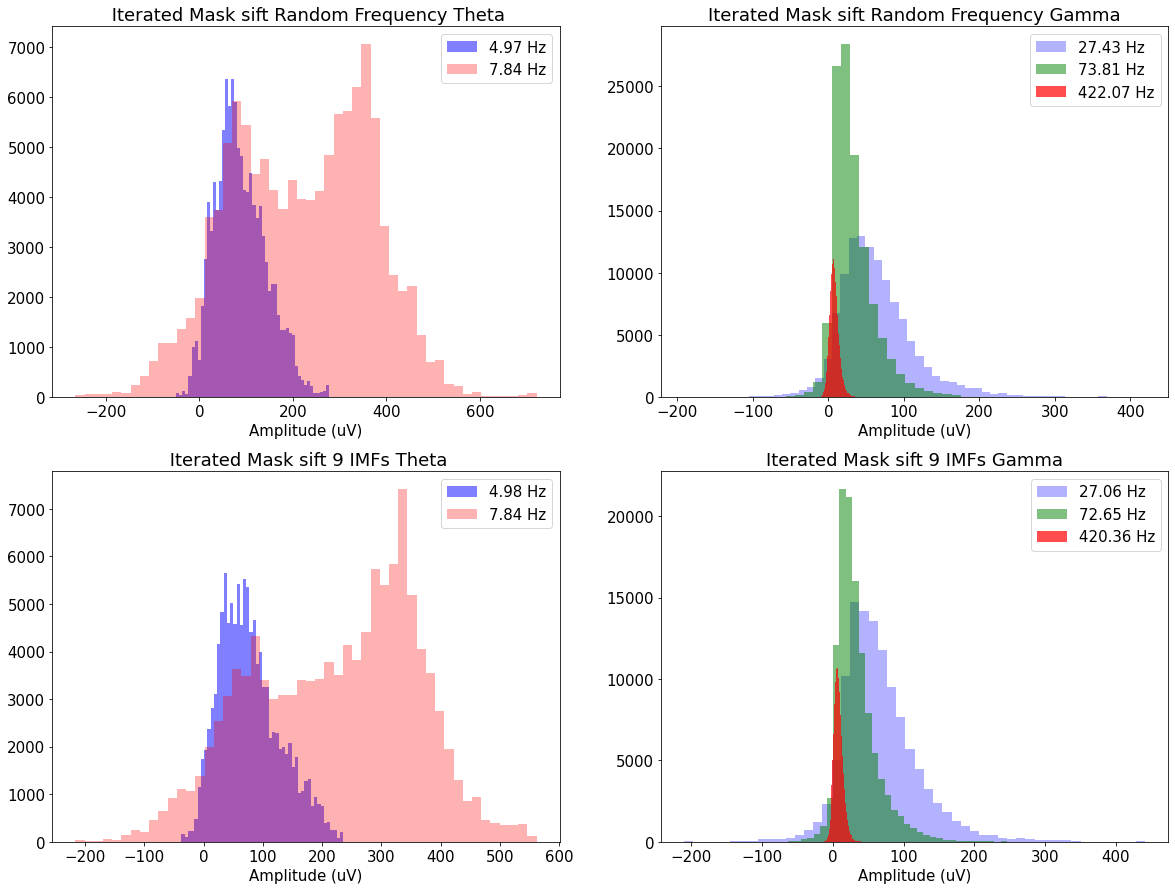

In [ ]:
imaskrand=emd.sift.iterated_mask_sift(REM[0],mask_0='random',sample_rate=2500,ret_mask_freq='True')
imaskrandft=emd.spectra.frequency_transform(imaskrand[0],2500,'nht')
imaskrandsplit=tgsplit(imaskrand,1,(4,12))
imask9=emd.sift.iterated_mask_sift(REM[0],mask_0='zc',max_imfs=9,sample_rate=2500,ret_mask_freq='True')
imask9ft=emd.spectra.frequency_transform(imask9[0],2500,'nht')
imask9split=tgsplit(imask9,1,(4,12))
fig10,ax10=plt.subplots(2,2,figsize=(20,15))
plt.rcParams.update({'font.size': 15})
## Iterated Mask Sift Random Frequency
ax10[0,0].hist(imaskrandft[2][:,imaskrandsplit[1][0]][:,1],bins=50,edgecolor='none',alpha=0.5,color='blue',label=str(np.round(imaskrand[1][imaskrandsplit[1]][1],2))+' Hz')
ax10[0,0].hist(imaskrandft[2][:,imaskrandsplit[1][0]][:,0],bins=50,edgecolor='none',alpha=0.3,color='red',label=str(np.round(imaskrand[1][imaskrandsplit[1]][0],2))+' Hz')
ax10[0,0].legend(loc="upper right")
ax10[0,1].hist(imaskrandft[2][:,imaskrandsplit[2][0]][:,2],bins=50,edgecolor='none',alpha=0.3,color='blue',label=str(np.round(imaskrand[1][imaskrandsplit[2]][2],2))+' Hz')
ax10[0,1].hist(imaskrandft[2][:,imaskrandsplit[2][0]][:,1],bins=50,edgecolor='none',alpha=0.5,color='green',label=str(np.round(imaskrand[1][imaskrandsplit[2]][1],2))+' Hz')
ax10[0,1].hist(imaskrandft[2][:,imaskrandsplit[2][0]][:,0],bins=50,edgecolor='none',alpha=0.7,color='red',label=str(np.round(imaskrand[1][imaskrandsplit[2]][0],2))+' Hz')
ax10[0,1].legend(loc="upper right")
ax10[0,0].set_title(' Iterated Mask sift Random Frequency Theta')
ax10[0,1].set_title('Iterated Mask sift Random Frequency Gamma')
ax10[0,0].set_xlabel(r'Amplitude (uV)')
ax10[0,1].set_xlabel(r'Amplitude (uV)')
## Iterated Mask Sift Max IMFs 9
ax10[1,0].hist(imask9ft[2][:,imask9split[1][0]][:,1],bins=50,edgecolor='none',alpha=0.5,color='blue',label=str(np.round(imask9[1][imask9split[1]][1],2))+' Hz')
ax10[1,0].hist(imask9ft[2][:,imask9split[1][0]][:,0],bins=50,edgecolor='none',alpha=0.3,color='red',label=str(np.round(imask9[1][imask9split[1]][0],2))+' Hz')
ax10[1,0].legend(loc="upper right")
ax10[1,1].hist(imask9ft[2][:,imask9split[2][0]][:,2],bins=50,edgecolor='none',alpha=0.3,color='blue',label=str(np.round(imask9[1][imask9split[2]][2],2))+' Hz')
ax10[1,1].hist(imask9ft[2][:,imask9split[2][0]][:,1],bins=50,edgecolor='none',alpha=0.5,color='green',label=str(np.round(imask9[1][imask9split[2]][1],2))+' Hz')
ax10[1,1].hist(imask9ft[2][:,imask9split[2][0]][:,0],bins=50,edgecolor='none',alpha=0.7,color='red',label=str(np.round(imask9[1][imask9split[2]][0],2))+' Hz')
ax10[1,1].legend(loc="upper right")
ax10[1,0].set_title(' Iterated Mask sift 9 IMFs Theta')
ax10[1,1].set_title('Iterated Mask sift 9 IMFs Gamma')
ax10[1,0].set_xlabel(r'Amplitude (uV)')
ax10[1,1].set_xlabel(r'Amplitude (uV)')

<ipython-input-25-4182c8f0bb7f>:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax11[0,0].hist(imaskft[2][:,imasksplit[1][0]][:,1],bins=50,edgecolor='none',alpha=1,color='blue',label=str(np.round(imask[1][imasksplit[1]][1]*2500,2))+' Hz')
<ipython-input-25-4182c8f0bb7f>:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax11[0,0].hist(imaskft[2][:,imasksplit[1][0]][:,0],bins=50,edgecolor='none',alpha=0.5,color='red',label=str(np.round(imask[1][imasksplit[1]][0]*2500,2))+' Hz')
<ipython-input-25-4182c8f0bb7f>:9: FutureWarning: Using a non-t

Text(0.5, 0, 'Frequency (Hz)')

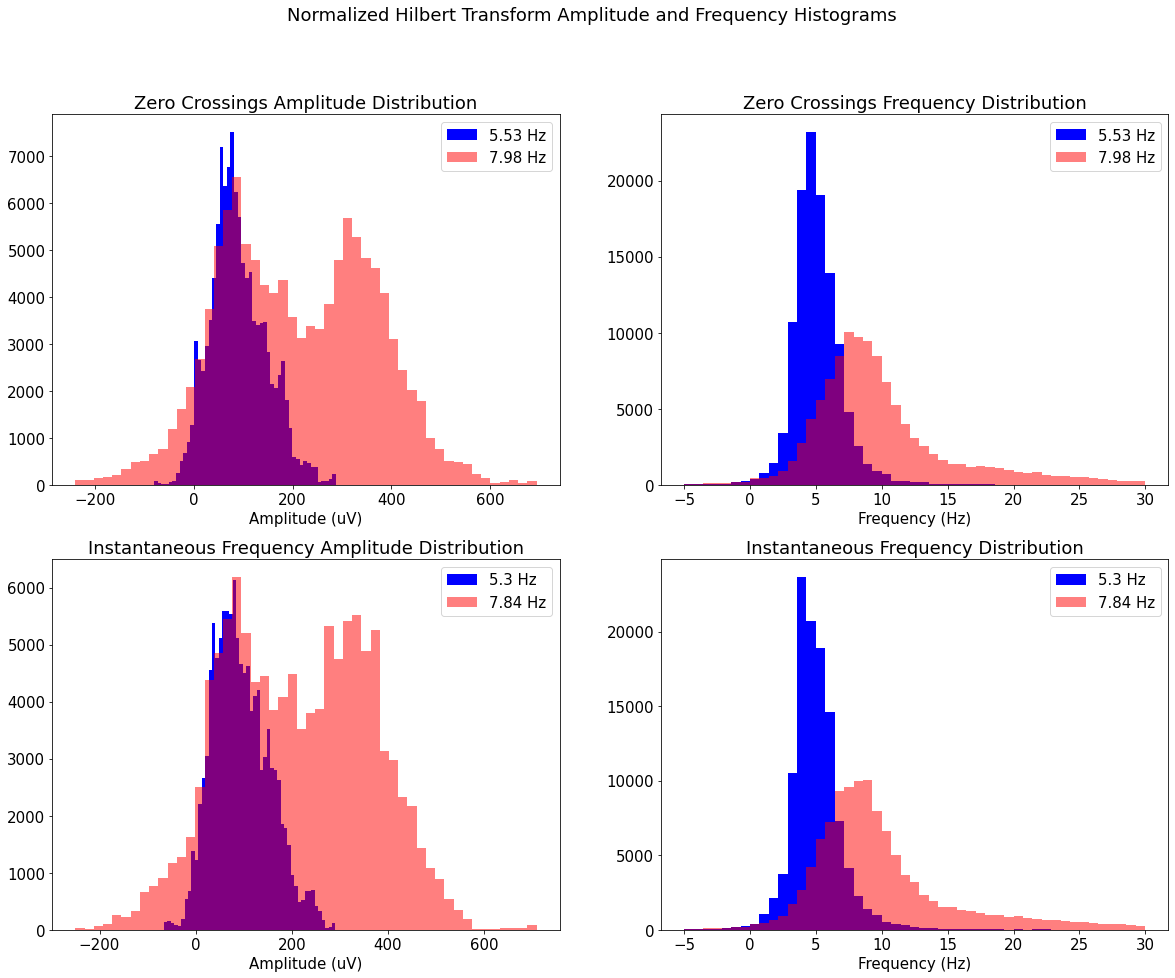

In [ ]:
#@title Histogram distribution of Theta-Gamma using Normalized Hilbert Transforms
fig11,ax11=plt.subplots(2,2,figsize=(20,15))
plt.rcParams.update({'font.size': 15})
fig11.suptitle('Normalized Hilbert Transform Amplitude and Frequency Histograms')
## Iterated Mask Sift Zero Crossings (Normalized Hilbert)
ax11[0,0].hist(imaskft[2][:,imasksplit[1][0]][:,1],bins=50,edgecolor='none',alpha=1,color='blue',label=str(np.round(imask[1][imasksplit[1]][1]*2500,2))+' Hz')
ax11[0,0].hist(imaskft[2][:,imasksplit[1][0]][:,0],bins=50,edgecolor='none',alpha=0.5,color='red',label=str(np.round(imask[1][imasksplit[1]][0]*2500,2))+' Hz')
ax11[0,0].legend(loc="upper right")
ax11[0,1].hist(imaskft[1][:,imasksplit[1][0]][:,1],bins=np.linspace(-5,30,50),edgecolor='none',alpha=1,color='blue',label=str(np.round(imask[1][imasksplit[1]][1]*2500,2))+' Hz')
ax11[0,1].hist(imaskft[1][:,imasksplit[1][0]][:,0],bins=np.linspace(-5,30,50),edgecolor='none',alpha=0.5,color='red',label=str(np.round(imask[1][imasksplit[1]][0]*2500,2))+' Hz')
# ax9[0,1].hist(imaskft[1][:,imasksplit[2][0]][:,0],bins=50,edgecolor='none',alpha=0.7,color='red',label=str(np.round(imask[1][imasksplit[2]][0]*2500,2))+' Hz')
ax11[0,1].legend(loc="upper right")
ax11[0,0].set_title('Zero Crossings Amplitude Distribution')
ax11[0,1].set_title('Zero Crossings Frequency Distribution')
ax11[0,0].set_xlabel(r'Amplitude (uV)')
ax11[0,1].set_xlabel(r'Frequency (Hz)')
## Iterated Mask Sift Instantaneous Frequency
ax11[1,0].hist(imaskifft[2][:,imaskifsplit[1][0]][:,1],bins=50,edgecolor='none',alpha=1,color='blue',label=str(np.round(imaskif[1][imaskifsplit[1]][1]*2500,2))+' Hz')
ax11[1,0].hist(imaskifft[2][:,imaskifsplit[1][0]][:,0],bins=50,edgecolor='none',alpha=0.5,color='red',label=str(np.round(imaskif[1][imaskifsplit[1]][0]*2500,2))+' Hz')
ax11[1,0].legend(loc="upper right")
ax11[1,1].hist(imaskifft[1][:,imaskifsplit[1][0]][:,1],bins=np.linspace(-5,30,50),edgecolor='none',alpha=1,color='blue',label=str(np.round(imaskif[1][imaskifsplit[1]][1]*2500,2))+' Hz')
ax11[1,1].hist(imaskifft[1][:,imaskifsplit[1][0]][:,0],bins=np.linspace(-5,30,50),edgecolor='none',alpha=0.5,color='red',label=str(np.round(imaskif[1][imaskifsplit[1]][0]*2500,2))+' Hz')
# ax9[1,1].hist(imaskifft[2][:,imaskifsplit[2][0]][:,0],bins=50,edgecolor='none',alpha=0.7,color='red',label=str(np.round(imaskif[1][imaskifsplit[2]][0]*2500,2))+' Hz')
ax11[1,1].legend(loc="upper right")
ax11[1,0].set_title('Instantaneous Frequency Amplitude Distribution')
ax11[1,1].set_title('Instantaneous Frequency Distribution')
ax11[1,0].set_xlabel(r'Amplitude (uV)')
ax11[1,1].set_xlabel(r'Frequency (Hz)')

<ipython-input-26-14065d429fe2>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax12[0,0].hist(imaskhft[2][:,imasksplit[1][0]][:,1],bins=50,edgecolor='none',alpha=1,color='blue',label=str(np.round(imask[1][imasksplit[1]][1]*2500,2))+' Hz')
<ipython-input-26-14065d429fe2>:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax12[0,0].hist(imaskhft[2][:,imasksplit[1][0]][:,0],bins=50,edgecolor='none',alpha=0.5,color='red',label=str(np.round(imask[1][imasksplit[1]][0]*2500,2))+' Hz')
<ipython-input-26-14065d429fe2>:11: FutureWarning: Using a no

Text(0.5, 0, 'Frequency (Hz)')

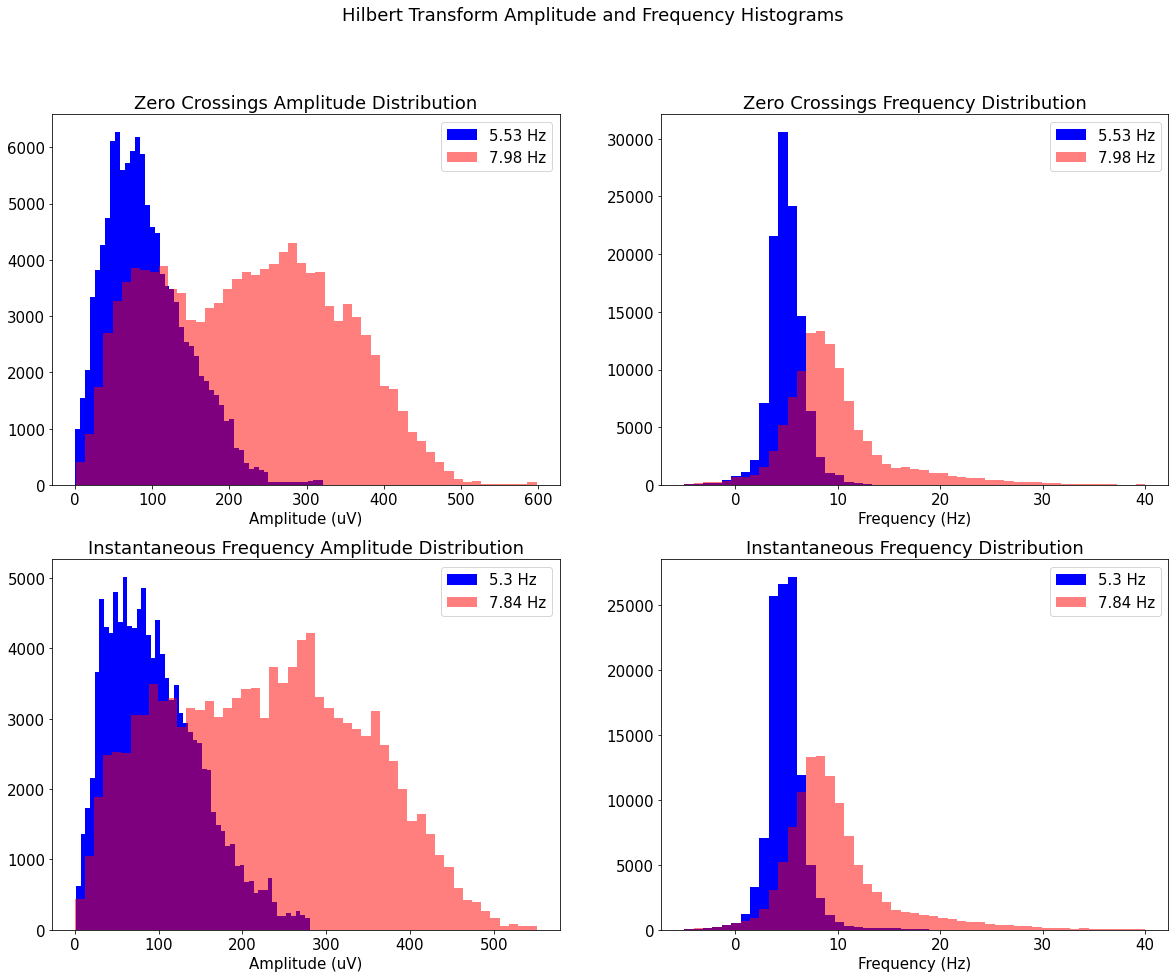

In [ ]:
#@title Histogram distribution of Theta-Gamma using Hilbert Transforms
imaskhft=emd.spectra.frequency_transform(imask[0],2500,'hilbert')
imaskifhft=emd.spectra.frequency_transform(imaskif[0],2500,'hilbert')
fig12,ax12=plt.subplots(2,2,figsize=(20,15))
plt.rcParams.update({'font.size': 15})
fig12.suptitle('Hilbert Transform Amplitude and Frequency Histograms')
## Iterated Mask Sift Zero Crossings
ax12[0,0].hist(imaskhft[2][:,imasksplit[1][0]][:,1],bins=50,edgecolor='none',alpha=1,color='blue',label=str(np.round(imask[1][imasksplit[1]][1]*2500,2))+' Hz')
ax12[0,0].hist(imaskhft[2][:,imasksplit[1][0]][:,0],bins=50,edgecolor='none',alpha=0.5,color='red',label=str(np.round(imask[1][imasksplit[1]][0]*2500,2))+' Hz')
ax12[0,0].legend(loc="upper right")
ax12[0,1].hist(imaskhft[1][:,imasksplit[1][0]][:,1],bins=np.linspace(-5,40,50),edgecolor='none',alpha=1,color='blue',label=str(np.round(imask[1][imasksplit[1]][1]*2500,2))+' Hz')
ax12[0,1].hist(imaskhft[1][:,imasksplit[1][0]][:,0],bins=np.linspace(-5,40,50),edgecolor='none',alpha=0.5,color='red',label=str(np.round(imask[1][imasksplit[1]][0]*2500,2))+' Hz')
# ax9[0,1].hist(imaskft[1][:,imasksplit[2][0]][:,0],bins=50,edgecolor='none',alpha=0.7,color='red',label=str(np.round(imask[1][imasksplit[2]][0]*2500,2))+' Hz')
ax12[0,1].legend(loc="upper right")
ax12[0,0].set_title('Zero Crossings Amplitude Distribution')
ax12[0,1].set_title('Zero Crossings Frequency Distribution')
ax12[0,0].set_xlabel(r'Amplitude (uV)')
ax12[0,1].set_xlabel(r'Frequency (Hz)')
## Iterated Mask Sift Instantaneous Frequency
ax12[1,0].hist(imaskifhft[2][:,imaskifsplit[1][0]][:,1],bins=50,edgecolor='none',alpha=1,color='blue',label=str(np.round(imaskif[1][imaskifsplit[1]][1]*2500,2))+' Hz')
ax12[1,0].hist(imaskifhft[2][:,imaskifsplit[1][0]][:,0],bins=50,edgecolor='none',alpha=0.5,color='red',label=str(np.round(imaskif[1][imaskifsplit[1]][0]*2500,2))+' Hz')
ax12[1,0].legend(loc="upper right")
ax12[1,1].hist(imaskifhft[1][:,imaskifsplit[1][0]][:,1],bins=np.linspace(-5,40,50),edgecolor='none',alpha=1,color='blue',label=str(np.round(imaskif[1][imaskifsplit[1]][1]*2500,2))+' Hz')
ax12[1,1].hist(imaskifhft[1][:,imaskifsplit[1][0]][:,0],bins=np.linspace(-5,40,50),edgecolor='none',alpha=0.5,color='red',label=str(np.round(imaskif[1][imaskifsplit[1]][0]*2500,2))+' Hz')
# ax9[1,1].hist(imaskifft[2][:,imaskifsplit[2][0]][:,0],bins=50,edgecolor='none',alpha=0.7,color='red',label=str(np.round(imaskif[1][imaskifsplit[2]][0]*2500,2))+' Hz')
ax12[1,1].legend(loc="upper right")
ax12[1,0].set_title('Instantaneous Frequency Amplitude Distribution')
ax12[1,1].set_title('Instantaneous Frequency Distribution')
ax12[1,0].set_xlabel(r'Amplitude (uV)')
ax12[1,1].set_xlabel(r'Frequency (Hz)')

<ipython-input-27-7c3881ba97b7>:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax13[0,0].hist(imaskqft[2][:,imasksplit[1][0]][:,1],bins=50,edgecolor='none',alpha=1,color='blue',label=str(np.round(imask[1][imasksplit[1]][1]*2500,2))+' Hz')
<ipython-input-27-7c3881ba97b7>:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ax13[0,0].hist(imaskqft[2][:,imasksplit[1][0]][:,0],bins=50,edgecolor='none',alpha=0.5,color='red',label=str(np.round(imask[1][imasksplit[1]][0]*2500,2))+' Hz')
<ipython-input-27-7c3881ba97b7>:11: FutureWarning: Using a no

Text(0.5, 0, 'Frequency (Hz)')

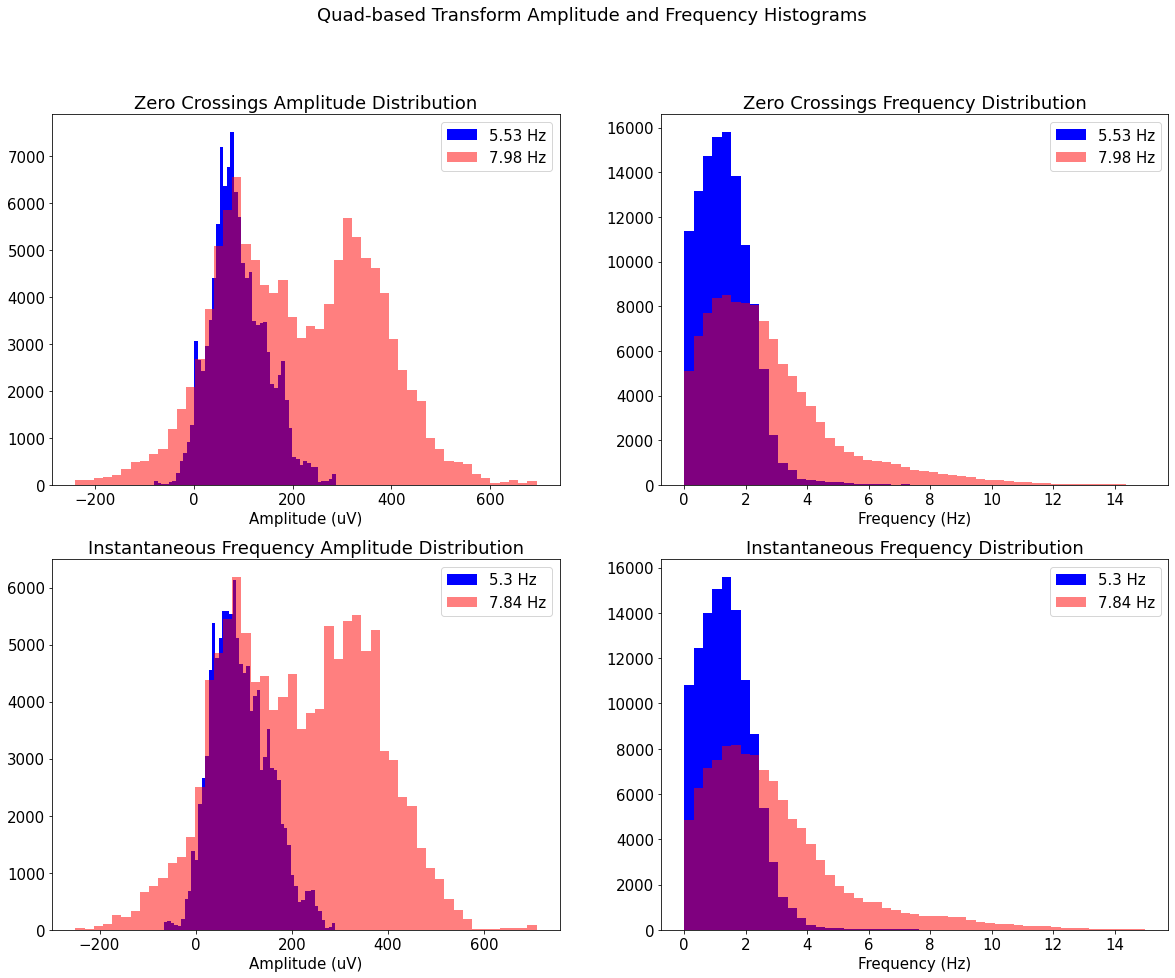

In [ ]:
#@title Histogram distribution of Theta-Gamma using Quad Based Transforms
imaskqft=emd.spectra.frequency_transform(imask[0],2500,'quad')
imaskifqft=emd.spectra.frequency_transform(imaskif[0],2500,'quad')
fig13,ax13=plt.subplots(2,2,figsize=(20,15))
plt.rcParams.update({'font.size': 15})
fig13.suptitle('Quad-based Transform Amplitude and Frequency Histograms')
## Iterated Mask Sift Zero Crossings
ax13[0,0].hist(imaskqft[2][:,imasksplit[1][0]][:,1],bins=50,edgecolor='none',alpha=1,color='blue',label=str(np.round(imask[1][imasksplit[1]][1]*2500,2))+' Hz')
ax13[0,0].hist(imaskqft[2][:,imasksplit[1][0]][:,0],bins=50,edgecolor='none',alpha=0.5,color='red',label=str(np.round(imask[1][imasksplit[1]][0]*2500,2))+' Hz')
ax13[0,0].legend(loc="upper right")
ax13[0,1].hist(imaskqft[1][:,imasksplit[1][0]][:,1],bins=np.linspace(0,15,50),edgecolor='none',alpha=1,color='blue',label=str(np.round(imask[1][imasksplit[1]][1]*2500,2))+' Hz')
ax13[0,1].hist(imaskqft[1][:,imasksplit[1][0]][:,0],bins=np.linspace(0,15,50),edgecolor='none',alpha=0.5,color='red',label=str(np.round(imask[1][imasksplit[1]][0]*2500,2))+' Hz')
# ax9[0,1].hist(imaskft[1][:,imasksplit[2][0]][:,0],bins=50,edgecolor='none',alpha=0.7,color='red',label=str(np.round(imask[1][imasksplit[2]][0]*2500,2))+' Hz')
ax13[0,1].legend(loc="upper right")
ax13[0,0].set_title('Zero Crossings Amplitude Distribution')
ax13[0,1].set_title('Zero Crossings Frequency Distribution')
ax13[0,0].set_xlabel(r'Amplitude (uV)')
ax13[0,1].set_xlabel(r'Frequency (Hz)')
## Iterated Mask Sift Instantaneous Frequency
ax13[1,0].hist(imaskifqft[2][:,imaskifsplit[1][0]][:,1],bins=50,edgecolor='none',alpha=1,color='blue',label=str(np.round(imaskif[1][imaskifsplit[1]][1]*2500,2))+' Hz')
ax13[1,0].hist(imaskifqft[2][:,imaskifsplit[1][0]][:,0],bins=50,edgecolor='none',alpha=0.5,color='red',label=str(np.round(imaskif[1][imaskifsplit[1]][0]*2500,2))+' Hz')
ax13[1,0].legend(loc="upper right")
ax13[1,1].hist(imaskifqft[1][:,imaskifsplit[1][0]][:,1],bins=np.linspace(0,15,50),edgecolor='none',alpha=1,color='blue',label=str(np.round(imaskif[1][imaskifsplit[1]][1]*2500,2))+' Hz')
ax13[1,1].hist(imaskifqft[1][:,imaskifsplit[1][0]][:,0],bins=np.linspace(0,15,50),edgecolor='none',alpha=0.5,color='red',label=str(np.round(imaskif[1][imaskifsplit[1]][0]*2500,2))+' Hz')
# ax9[1,1].hist(imaskifft[2][:,imaskifsplit[2][0]][:,0],bins=50,edgecolor='none',alpha=0.7,color='red',label=str(np.round(imaskif[1][imaskifsplit[2]][0]*2500,2))+' Hz')
ax13[1,1].legend(loc="upper right")
ax13[1,0].set_title('Instantaneous Frequency Amplitude Distribution')
ax13[1,1].set_title('Instantaneous Frequency Distribution')
ax13[1,0].set_xlabel(r'Amplitude (uV)')
ax13[1,1].set_xlabel(r'Frequency (Hz)')

In [ ]:
# siftfig=emd.plotting.plot_imfs(sift[:2500,:]).get_figure()
# ensemblefig=emd.plotting.plot_imfs(ensemble[:2500,:]).get_figure()
# censemblefig=emd.plotting.plot_imfs(censemble[:2500,:]).get_figure()
# maskzcfig=emd.plotting.plot_imfs(maskzc[0][:2500,:]).get_figure()
# maskiffig=emd.plotting.plot_imfs(maskif[0][:2500,:]).get_figure()
# imaskzcfig=emd.plotting.plot_imfs(imask[0][:2500,:]).get_figure()
# imaskiffig=emd.plotting.plot_imfs(imaskif[0][:2500,:]).get_figure()
# imaskrandfig=emd.plotting.plot_imfs(imaskrand[0][:2500,:]).get_figure()
# imask9fig=emd.plotting.plot_imfs(imask9[0][:2500,:]).get_figure()

In [ ]:
# siftfig.savefig(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/Sifts/siftIMF.pdf')
# ensemblefig.savefig(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/Sifts/ensembleIMF.pdf')
# censemblefig.savefig(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/Sifts/censembleIMF.pdf')
# maskzcfig.savefig(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/Sifts/maskzcIMF.pdf')
# maskiffig.savefig(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/Sifts/maskifIMF.pdf')
# imaskzcfig.savefig(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/Sifts/imaskzcIMF.pdf')
# imaskiffig.savefig(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/Sifts/imaskifIMF.pdf')
# imaskrandfig.savefig(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/Sifts/imaskrandIMF.pdf')
# imask9fig.savefig(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/Sifts/imask9IMF.pdf')

# fig1.savefig(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/RawVSTheta/fig1.pdf')
# fig2.savefig(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/RawVSTheta/fig2.pdf')

# fig7.savefig('/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/Amplitude_Histograms/fig7.png')
# fig8.savefig('/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/Amplitude_Histograms/fig8.png')
# fig9.savefig('/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/Amplitude_Histograms/fig9.png')
# fig10.savefig('/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/Amplitude_Histograms/fig10.png')

In [ ]:
# phaseplot=np.linspace(0,360,19)
# for i,rem in enumerate(np.nditer(remfpp[::1,:,:])):
#   plt.gcf().set_size_inches(8, 10)
#   plt.contourf(phaseplot,remfreq,remfpp[i],vmin=np.min(tf[19:199]),vmax=np.max(tf[19:199]))
#   plt.title('Cycle '+str(i+1))
#   plt.xticks([0,45,90,135,180,225,270,315,360])
#   plt.yticks([20,40,60,80,100,120,140,160,180,200])
#   plt.xlabel(r'Phase(deg)')
#   plt.ylabel(r'Power')
#   # plt.savefig(r'/content/drive/MyDrive/ThetaGamma/Rat/4/SD1/Figures/FPPplot/Cycle'+str(i+1)+'.pdf')


# Theta cycle definition function

## Vertical features threshold definition

In this section we investigate what governs the behavior of theta ammplitudes.
- One of our assumptions is to take 2 times the standard deviation of the distribution, but this would ignore outliers in the positive amplitudes, which are definitely peaks
-A better assumption of minimum theta amplitude threshold is that we take 2 times the standard deviation of subtheta signals provided the distribution is not the same as theta.


This is on the basis we are investigating inter-trough windows theta cycles for our vertical thresholds (amplitude).

Text(0.5, 0.98, 'Comparison of REM epoch amplitudes (5-8)')

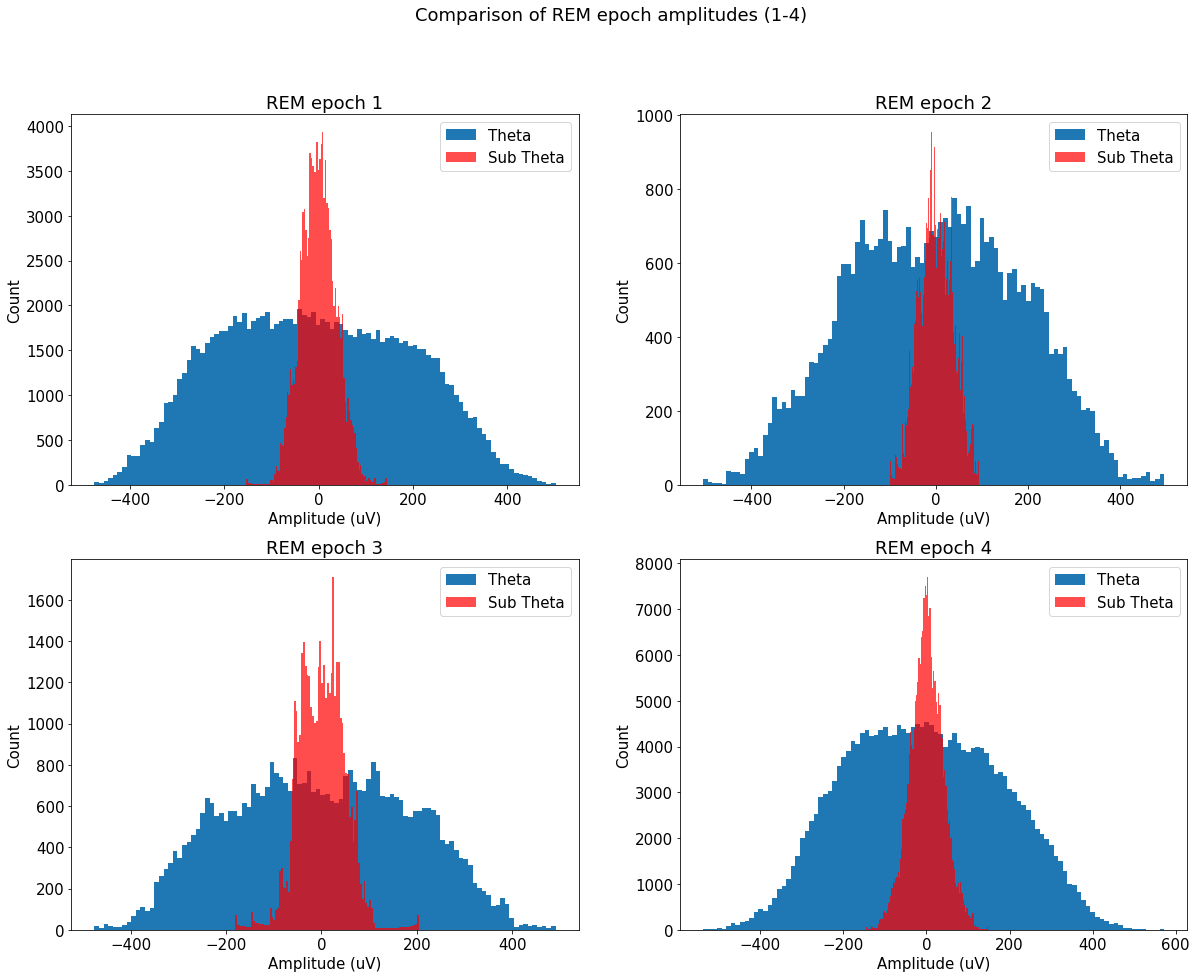

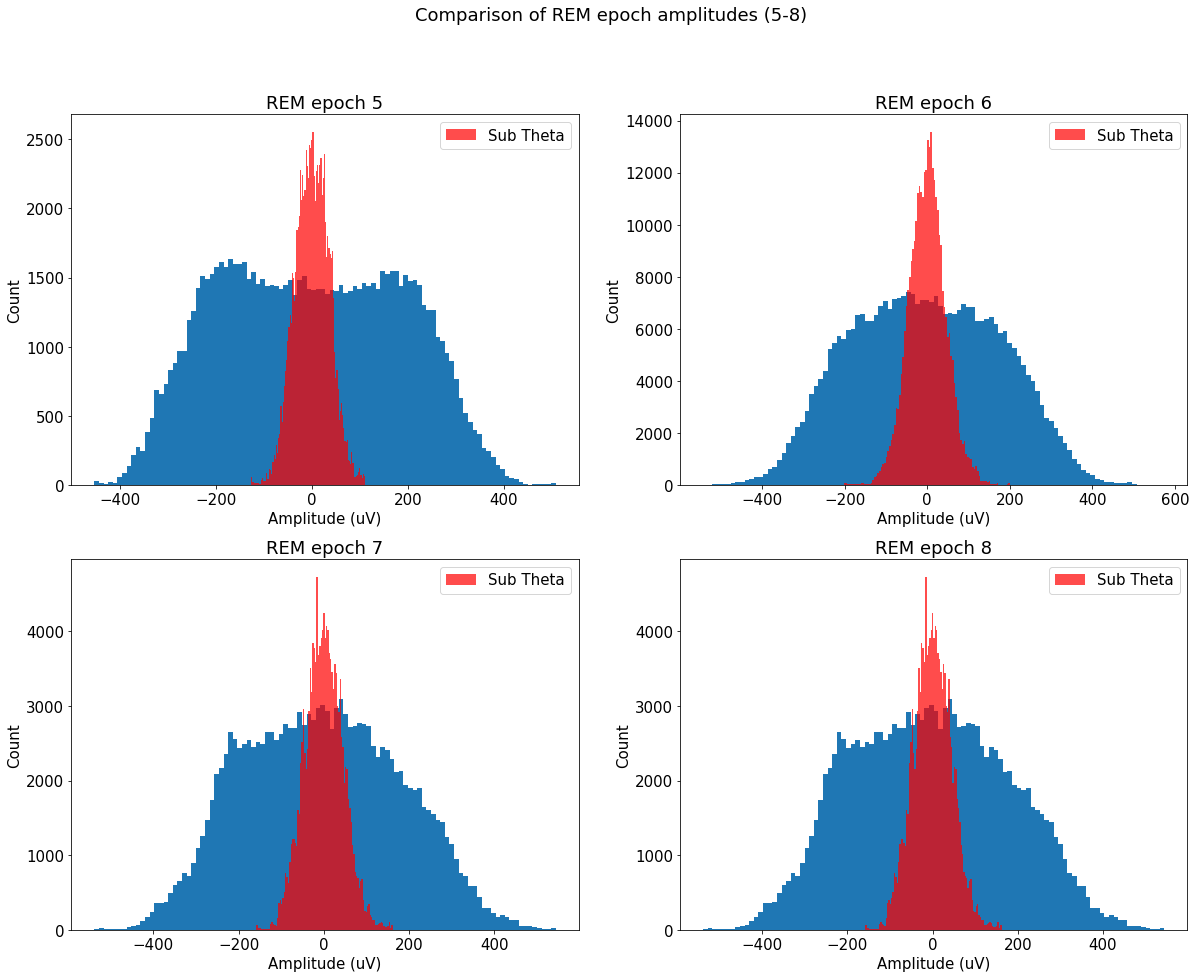

In [ ]:
#@title Comparing REM epochs individually
imask1=emd.sift.iterated_mask_sift(REM[1],mask_0='zc',ret_mask_freq=True)
# 2 outputs in the form of tuple (imfs, 1d all the frequencies)
# indexes match the mask freq vector index, ordered from highest (0) to lowest (n) frequencies
# Boolean condition that gives a boolean vector of the same column dimension of mask freq vector
# subset with boolean vector orignal imfs = gives theta imfs
imask1split= tgsplit(imask1,2500)
imask2=emd.sift.iterated_mask_sift(REM[2],mask_0='zc',ret_mask_freq=True)
imask2split= tgsplit(imask2,2500)
imask3=emd.sift.iterated_mask_sift(REM[3],mask_0='zc',ret_mask_freq=True)
imask3split= tgsplit(imask3,2500)
imask4=emd.sift.iterated_mask_sift(REM[4],mask_0='zc',ret_mask_freq=True)
imask4split= tgsplit(imask4,2500)
imask5=emd.sift.iterated_mask_sift(REM[5],mask_0='zc',ret_mask_freq=True)
imask5split= tgsplit(imask5,2500)
imask6=emd.sift.iterated_mask_sift(REM[6],mask_0='zc',ret_mask_freq=True)
imask6split= tgsplit(imask6,2500)
imask7=emd.sift.iterated_mask_sift(REM[7],mask_0='zc',ret_mask_freq=True)
imask7split= tgsplit(imask7,2500)
## Theta
imask1sig=np.sum(imask1[0][:,imask1split[1][0]],axis=1)
imask2sig=np.sum(imask2[0][:,imask2split[1][0]],axis=1)
imask3sig=np.sum(imask3[0][:,imask3split[1][0]],axis=1)
imask4sig=np.sum(imask4[0][:,imask4split[1][0]],axis=1)
imask5sig=np.sum(imask5[0][:,imask5split[1][0]],axis=1)
imask6sig=np.sum(imask6[0][:,imask6split[1][0]],axis=1)
imask7sig=np.sum(imask6[0][:,imask7split[1][0]],axis=1)

## Sub-theta
subimask0sig=np.sum(imask[0][:,imasksplit[0][0]],axis=1)
subimask1sig=np.sum(imask1[0][:,imask1split[0][0]],axis=1)
subimask2sig=np.sum(imask2[0][:,imask2split[0][0]],axis=1)
subimask3sig=np.sum(imask3[0][:,imask3split[0][0]],axis=1)
subimask4sig=np.sum(imask4[0][:,imask4split[0][0]],axis=1)
subimask5sig=np.sum(imask5[0][:,imask5split[0][0]],axis=1)
subimask6sig=np.sum(imask6[0][:,imask6split[0][0]],axis=1)
subimask7sig=np.sum(imask6[0][:,imask7split[0][0]],axis=1)

#Plots
thetasignal=np.sum(imask[0][:,imasksplit[1][0]],axis=1)
REMcomplete= np.concatenate((thetasignal,imask1sig,imask2sig,imask3sig,imask4sig,imask5sig,imask6sig,imask7sig), axis=None)
subthetacomplete= np.concatenate((subimask0sig,subimask1sig,subimask2sig,subimask3sig,subimask4sig,subimask5sig,subimask6sig,subimask7sig), axis=None)


fig14,ax14=plt.subplots(2,2,figsize=(20,15))
plt.rcParams.update({'font.size': 15})
ax14[0,0].hist(thetasignal,bins=100,label='Theta')
ax14[0,0].set_title('REM epoch 1')
ax14[0,0].set_xlabel(r'Amplitude (uV)')
ax14[0,0].set_ylabel(r'Count')
ax14[0,1].hist(imask1sig,bins=100,label='Theta')
ax14[0,1].set_title('REM epoch 2')
ax14[0,1].set_xlabel(r'Amplitude (uV)')
ax14[0,1].set_ylabel(r'Count')
ax14[1,0].hist(imask2sig,bins=100,label='Theta')
ax14[1,0].set_title('REM epoch 3')
ax14[1,0].set_xlabel(r'Amplitude (uV)')
ax14[1,0].set_ylabel(r'Count')
ax14[1,1].hist(imask3sig,bins=100,label='Theta')
ax14[1,1].set_title('REM epoch 4')
ax14[1,1].set_xlabel(r'Amplitude (uV)')
ax14[1,1].set_ylabel(r'Count')



ax14[0,0].hist(subimask0sig,bins=100, color='red',alpha=0.7,label='Sub Theta')
ax14[0,0].legend(loc="upper right")
ax14[0,1].hist(subimask1sig,bins=100,color='red',alpha=0.7,label='Sub Theta')
ax14[0,1].legend(loc="upper right")
ax14[1,0].hist(subimask2sig,bins=100,color='red',alpha=0.7,label='Sub Theta')
ax14[1,0].legend(loc="upper right")
ax14[1,1].hist(subimask3sig,bins=100,color='red',alpha=0.7,label='Sub Theta')
ax14[1,1].legend(loc="upper right")
fig14.suptitle('Comparison of REM epoch amplitudes (1-4)')
fig15,ax15=plt.subplots(2,2,figsize=(20,15))
plt.rcParams.update({'font.size': 15})
ax15[0,0].hist(imask4sig,bins=100)
ax15[0,0].set_title('REM epoch 5')
ax15[0,0].set_xlabel(r'Amplitude (uV)')
ax15[0,0].set_ylabel(r'Count')
ax15[0,1].hist(imask5sig,bins=100)
ax15[0,1].set_title('REM epoch 6')
ax15[0,1].set_xlabel(r'Amplitude (uV)')
ax15[0,1].set_ylabel(r'Count')
ax15[1,0].hist(imask6sig,bins=100)
ax15[1,0].set_title('REM epoch 7')
ax15[1,0].set_xlabel(r'Amplitude (uV)')
ax15[1,0].set_ylabel(r'Count')
ax15[1,1].hist(imask7sig,bins=100)
ax15[1,1].set_title('REM epoch 8')
ax15[1,1].set_xlabel(r'Amplitude (uV)')
ax15[1,1].set_ylabel(r'Count')
ax15[0,0].hist(subimask4sig,bins=100, color='red',alpha=0.7,label='Sub Theta')
ax15[0,0].legend(loc="upper right")
ax15[0,1].hist(subimask5sig,bins=100,color='red',alpha=0.7,label='Sub Theta')
ax15[0,1].legend(loc="upper right")
ax15[1,0].hist(subimask6sig,bins=100,color='red',alpha=0.7,label='Sub Theta')
ax15[1,0].legend(loc="upper right")
ax15[1,1].hist(subimask7sig,bins=100,color='red',alpha=0.7,label='Sub Theta')
ax15[1,1].legend(loc="upper right")
fig15.suptitle('Comparison of REM epoch amplitudes (5-8)')

Text(0, 0.5, 'Count')

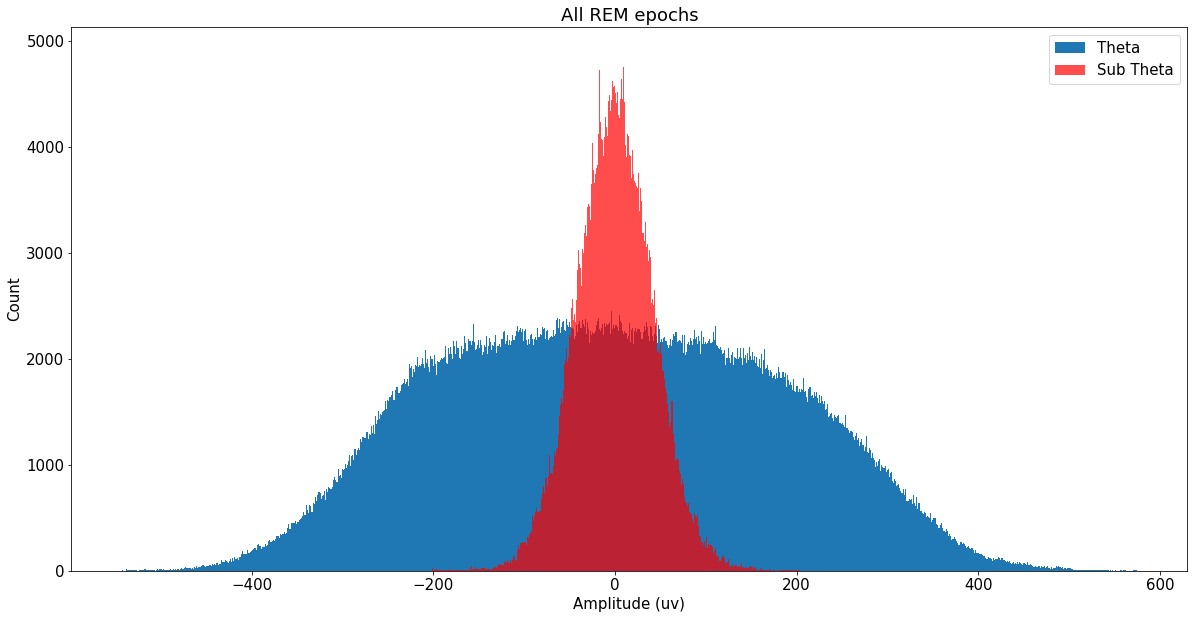

In [ ]:
#@title Distribution behaviour of all REM epochs concatenated
plt.gcf().set_size_inches(20, 10)
plt.hist(REMcomplete,bins=1000,label='Theta')
plt.hist(subthetacomplete,bins=1000,alpha=0.7,color='red',label='Sub Theta')
plt.legend()
plt.title('All REM epochs')
plt.xlabel("Amplitude (uv)")
plt.ylabel("Count")

#### Theta peaks amplitude threshold
Based on the distribution histograms above, we will be setting a minimum threshold of our peaks to 2 standard deviations positive

## Extrema Detection Analysis

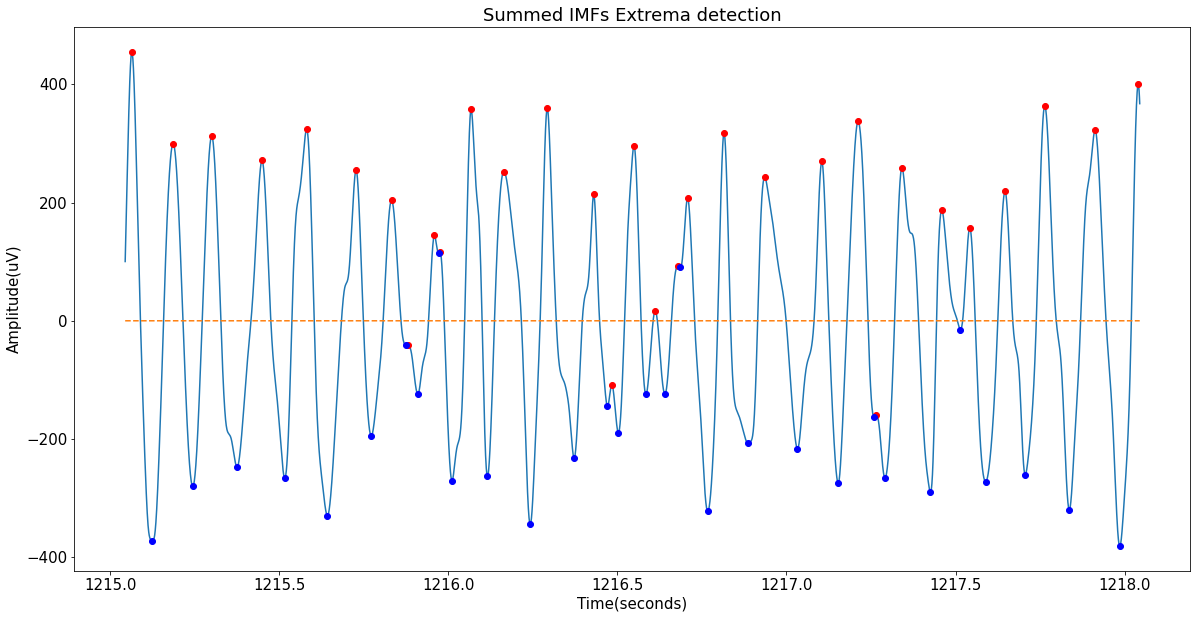

In [ ]:
#@markdown - Development of an algorithm of troughs and peaks
#@markdown - Trough to Trough locations are required for frequency thresholds
#@markdown - Individual Peak locations are required for amplitude thresholds
#@markdown - Threshold satisfaction of a trough to trough and peak pair would indicate a good theta cycle.
troughs=scipy.signal.argrelmin(np.sum(imask[0][:,imasksplit[1][0]],axis=1)[0:7500])
peaks= scipy.signal.argrelmax(np.sum(imask[0][:,imasksplit[1][0]],axis=1)[0:7500])
thetasignal=np.sum(imask[0][:,imasksplit[1][0]],axis=1)[0:7500]
plt.gcf().set_size_inches(20, 10)
plt.plot(seconds[0:7500],thetasignal)
plt.plot(seconds[peaks[0]],thetasignal[peaks[0]], "o",color='red')
plt.plot(seconds[troughs[0]],thetasignal[troughs[0]], "o",color='blue')
plt.plot(seconds[0:7500],np.zeros(7500),'--')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude(uV)')
plt.title('Summed IMFs Extrema detection')
plt.show()

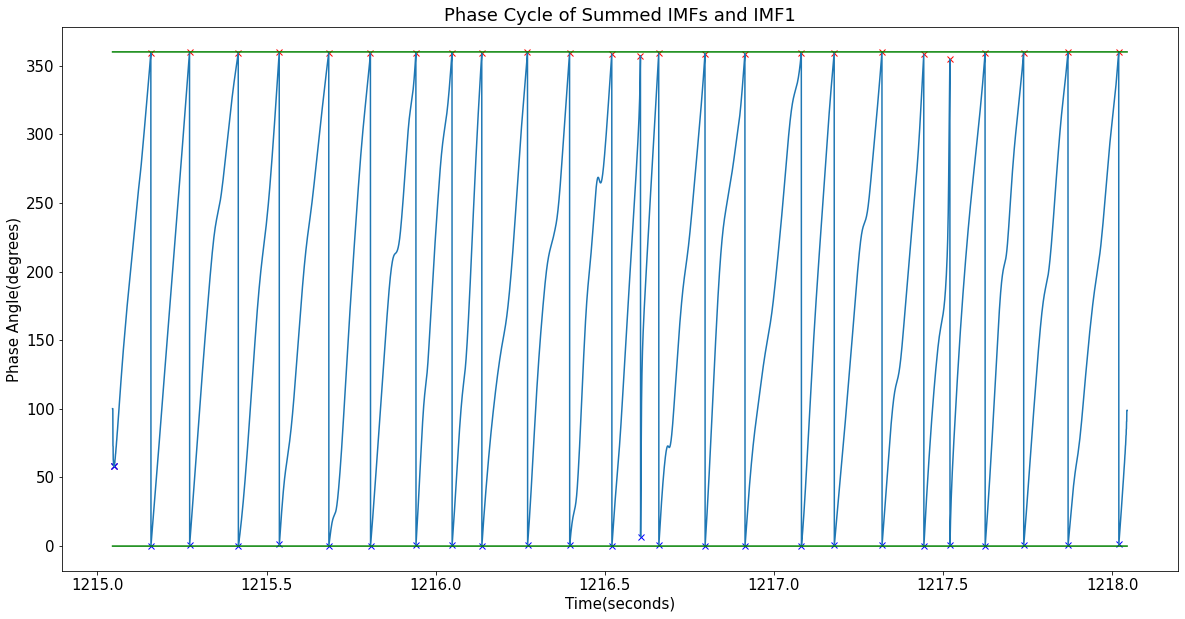

In [ ]:
#@title Zero crossing detection

#@markdown - Detection of full cycle period using instantaneous phase information

imaskftwrap,_,_=np.degrees(emd.spectra.frequency_transform(np.sum(imask[0][:,imasksplit[1][0]],axis=1)[0:7500],2500,'hilbert'))

high=scipy.signal.argrelmax(imaskftwrap)[0]
low=scipy.signal.argrelmin(imaskftwrap)[0]
plt.plot(seconds[high],imaskftwrap[high], "x",color='red')
plt.plot(seconds[low],imaskftwrap[low], "x",color='blue')
plt.gcf().set_size_inches(20, 10)
plt.plot(seconds[0:7500],imaskftwrap,label='Summed IMF Phase')
plt.plot(seconds[0:7500],360*np.ones(7500),'g')
plt.plot(seconds[0:7500],np.zeros(7500),'g')
plt.xlabel('Time(seconds)')
plt.ylabel('Phase Angle(degrees)')
plt.title('Phase Cycle of Summed IMFs and IMF1')
plt.show()

## ★ Definition of Extrema Detection Function
- Using the instantaneous phase information we identify the locations of zero-crossings of when cycle starts and stops
- Each cycle has one peak (max value) and one trough (min value)
- Output the location of these values

In [ ]:
def zerocross(x,smprate):
  IP,_,_=np.degrees(emd.spectra.frequency_transform(x,smprate,'hilbert'))
  phasemin=scipy.signal.argrelmin(IP)[0]
  return phasemin
def extrema(x,smprate):
  timestamps=zerocross(x,smprate)
  troughs=[]
  peaks=[]
  for i,(period1,period2) in enumerate(zip(timestamps,timestamps[1:])):
    troughs[i:]=[np.argmin(x[period1:period2])+period1]
    peaks[i:]=[np.argmax(x[period1:period2])+period1]
  minfilt= x[troughs]<0
  maxfilt= x[peaks]>0
  troughs=np.array(troughs)
  troughs=troughs[minfilt]
  peaks=np.array(peaks)
  peaks=peaks[maxfilt]
  return troughs, peaks

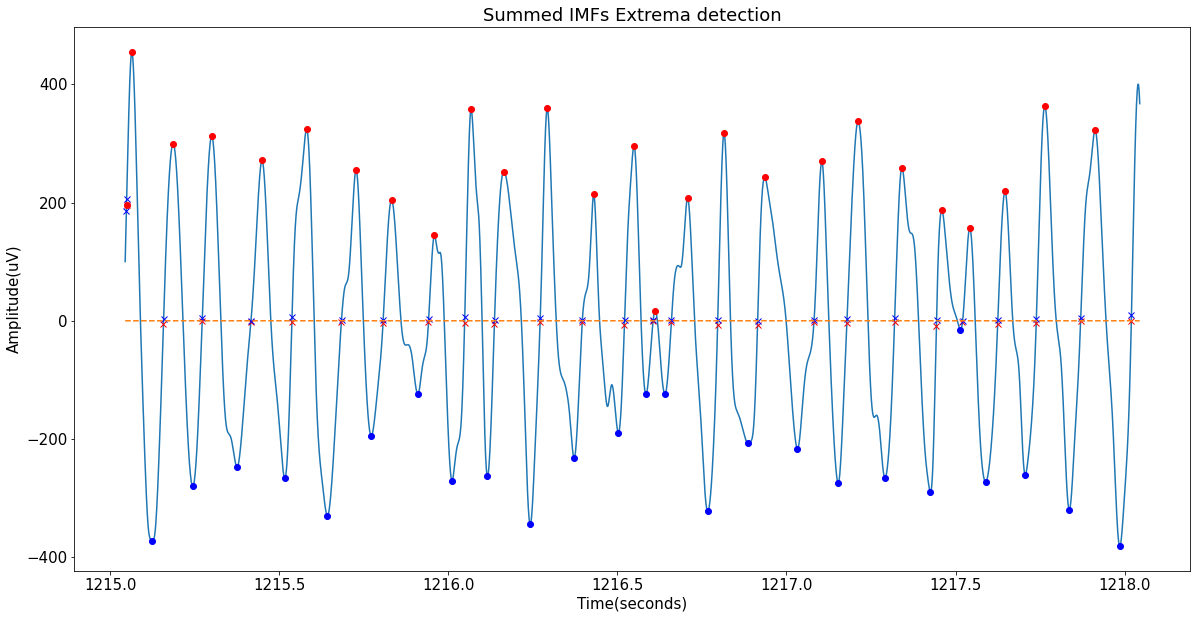

In [ ]:
#@title Demonstration of updated extrema detection
low2=zerocross(thetasignal,2500)
extremat,extremap=extrema(thetasignal,2500)
plt.gcf().set_size_inches(20, 10)
plt.plot(seconds[0:7500],thetasignal)
plt.plot(seconds[high],thetasignal[high], "x",color='red')
plt.plot(seconds[low],thetasignal[low], "x",color='blue')
plt.plot(seconds[extremap],thetasignal[extremap], "o",color='red')
plt.plot(seconds[extremat],thetasignal[extremat], "o",color='blue')
plt.plot(seconds[0:7500],np.zeros(7500),'--')
plt.xlabel('Time(seconds)')
plt.ylabel('Amplitude(uV)')
plt.title('Summed IMFs Extrema detection')
plt.show()

## Patching it all together

### ★ Definition of the Frequency Phase Power Matrix Generator Function

- Design a function that takes input parameters and provides the required data structures (Frequency Phase Power matrix) for our machine learning pipeline.
- First proposition for demonstrative purposes is to build a black box model
- In order to satisfy a cycle a trough($T_n$) and it's proceeding trough ($T_{n+1}$) should satisfy the  frequency conditions 5 Hz (200ms) to 12 Hz (83ms) :

- $$ 83\gt|T_n-T_{n+1}|\leq 200$$
- And a peak($P$) located between the troughs ($T_n \gets\to  T_{n+1}$) should satisfy the condition below of all concatenated REM periods:

- $$ P_m \geq 2\times \sigma_{subtheta}$$

In [ ]:
def fppgen(x,smprate,thetarange=(5,12),statmode='mean',bincount=19):
    tf,freqvec = morspecmat(x,smprate,freqrange=(20,200), zscore=True) # Morlet wavelet spectrogram
    imf=emd.sift.iterated_mask_sift(x,mask_0='zc',ret_mask_freq='True') # Computes and provides tuple of IMF and Frequency Vector of IMFs
    # Extracting IMF signals
    signals=imf[0]
    # Extracting the Frequency range
    subtheta, theta, _=tgsplit(imf,smprate,thetarange) #function to extract IMFs within thetarange
    # Construction of the theta signal
    thetasig=np.sum(signals[:,theta[0]],axis=1) #Sum signals within the range
    # Identify peaks and troughs
    troughs,peaks=extrema(thetasig,smprate) #extrema detection Ts and Ps
    # Setting Amplitude Lower Threshold
    minAmpsig=np.sum(signals[:,subtheta[0]],axis=1) # Extracting the subtheta signal
    minAmp=2*np.std(minAmpsig) # Setting the minimum Amplitude
    if peaks[0]<troughs[0]:
      peaks=peaks[1:] #arranging order of Ts and Ps with a T occurring first
    minAmpthetasig= thetasig[peaks]>=minAmp #boolean mask of peak locations that satisfy the amplitude threshold
    # Setting cycle frequency boundary conditions within the frequency range
    upperdiff=np.floor(1000/np.min(thetarange)) #200ms
    lowerdiff=np.floor(1000/np.max(thetarange)) #83ms
    difftrf=np.diff(troughs)*(1000/smprate) # scaling the differences between trough locations into miliseconds
    diffmask= np.logical_and(difftrf>=lowerdiff,difftrf<upperdiff) # creating a boolean shape mask of difftrf array that satisfy frequency threshold
    fpp=[]
    for i,(trf1,trf2,diff,peakAmp) in enumerate(zip(troughs,troughs[1:],
                                                    diffmask,minAmpthetasig)): 
    #loop condition that iterates over every pair of trough locations, frequency threshold, and ampltude threshold boolean values 
      if diff == True & peakAmp== True:
        binrangetrf=np.arange(trf1,trf2,1)
        fpp[i:]=[scipy.stats.binned_statistic(binrangetrf,tf[:,trf1:trf2],str(statmode), bins=int(bincount))[0]] #appending good theta cycles into a larger array
      else:
        continue  #skipping bad cycles
    fpp=np.array(fpp)
    return fpp, freqvec, tf #output the FPP matrix, a frequency vector, and the original time frequncy matrix

# Data Preprocessing and Machine Learning Pipeline

In this section we will be refactoring our methods to scale our Frequency Phase Power Matrix Generator for larger datasets

A few things to consider

- Group similar functions together in our loops
- Use lists instead of arrays since REM epoch timelines are not of the same size
- Chop out the REM epoch from the main signal and store them in one list
- Do individual sifts and wavelet transforms on each REM epoch

## ★ Sleep Extraction Function

This function serves as a method to extract the REM periods from our sleep recordings

In [ ]:
def sleepextract(x,smprate):
  if isinstance(x,dict):
    states=x['states']
    transitions=x['transitions']
    sleep_transitions=transitions[transitions[:,0]==5][:,-2:]
    sleep_trans=np.floor(sleep_transitions*smprate)
    return sleep_trans
def remextract(x,y):
    remsleep=y
    REM=[]
    for rem in remsleep:
        t1=int(rem[0])
        t2=int(rem[1])
        REM.append(x[t1:t2])
    return REM
def sigsort(x,smprate,sleep_states):
    remstate=sleepextract(sleep_states,smprate)
    rem=remextract(x,remstate)
    return rem

## ★ Trimming the Theta Gamma Split Function

Iterated Mask Sift provides the best performance following the trail of the signal and consequently the locations of our troughs and peaks. Therefore we can call the average frequencies of each IMF from the ```emd``` library by just passing a ```ret_mask_freq=True``` when running a sift

In [ ]:
def tgsplit(x,freqrange=(5,12)):
  lower=np.min(freqrange)
  upper=np.max(freqrange)
  mask_freq=x
  maskindex=np.logical_and(mask_freq>=lower,mask_freq<upper)
  submaskindex=mask_freq<lower
  supramaskindex=mask_freq>upper
  sub=[submaskindex]
  theta=[maskindex]
  supra=[supramaskindex]

  return sub,theta,supra

## ★ Frequency Phase Power Matrix Function v2.0

An updated version FPP function to handle large datasets of signals or, period epochs. This is a convenient black box function for Theta Gamma Analysts to out put spectral information into neat little binned slices.

Fixes and improvements.

- Make the code less purpose specific and open-ended for other oscillatory phenomena
- Error handling catch statements and documentation
- Clean up subsetting data, using transposed orientations

In [ ]:
def fppgenv2(x,smprate,freqrange=(15,200),zscore=True,mode='power',thetarange=(5,12),statmode='mean',bincount=19):
  data=x
  thetasig=[]
  subthetasig=[]
  tf=[]
# Signal Category Sepraration and time/frequency spectogram
  for dat in data:
    imf,freqvec=emd.sift.iterated_mask_sift(dat,sample_rate=smprate,mask_0='zc',ret_mask_freq='True')
    subtheta,theta,supratheta=tgsplit(freqvec)
    thetasig.append(np.sum(imf[:,theta[0]],axis=1))
    subthetasig.append(np.sum(imf[:,subtheta[0]],axis=1))
    suprathetasig=np.sum(imf[:,supratheta[0]],axis=1)
    #Originally done on the raw signal, now wavelet transform will be applied on the supratheta gamma signals
    tf.append(morspecmat(suprathetasig,smprate,freqrange,zscore=zscore,mode=mode))
# Threshhold definition
  troughs=[]
  peaks=[]
  minAmp=[]
  for theta,subtheta in zip(thetasig,subthetasig):
    troughs.append(extrema(theta,smprate)[0])
    peaks.append(extrema(theta,smprate)[1])
    minAmp.append(2*np.std(subtheta))
  minAmp=np.array(minAmp)
# Mask Definition
  diffmask=[]
  amppeak=[]
  # Setting cycle frequency boundary conditions within the frequency range
  upperdiff=np.floor(1000/np.min(thetarange))
  lowerdiff=np.floor(1000/np.max(thetarange))
  for peak,trough,min,theta in zip(peaks,troughs,minAmp,thetasig):
    if peak[0]<trough[0]:
        peak=peak[1:]
    elif peak[-1]>trough[-1]:
        peak=peak[:-1]
    amppeak.append(theta[peak]>=min)
    difftrf=np.diff(trough)*(1000/smprate)
    diffmask.append(np.logical_and(difftrf>=lowerdiff,difftrf<upperdiff))
# Slicing Theta Cycles: Make a separate function
  fpp=[]
  for trough,mask,peakamp,tfrem in zip(troughs,diffmask,amppeak,tf):
    #Find an alterntive to nesting a loop within a loop
    for trf1,trf2,diff,ampmin in zip(trough,trough[1:],mask,peakamp): 
      if diff == True & ampmin== True:
        binrangetrf=np.arange(trf1,trf2,1)
        fpp.append(scipy.stats.binned_statistic(binrangetrf,tfrem[:,trf1:trf2],str(statmode), bins=int(bincount))[0])
  fpp=np.array(fpp)
  return fpp

## Initial Batch Trial Analysis

An analysis of the upscaled methodology on a dataset. Originally the code was designed to deal with the performance with one REM epoch of sleep data for a data. This will slightly be taken further by handling all the REM epochs

In [ ]:
#@title Constructing the Data Structure
#@markdown - Extract REM epochs from sleep data and contain them into a list most preferably
#@markdown - Feed the REM epoch list into the ```fppgenv2()``` function 

REM=sigsort(lfp,2500,sleep)
thetacycles=fppgenv2(REM,2500,(15,120))
thetacycles2=fppgenv2(REM,2500,(15,120),mode='power',zscore=False)
print(thetacycles.shape,thetacycles2.shape)

(3022, 105, 19) (3022, 105, 19)


Text(0.5, 1.0, 'Power spectrum')

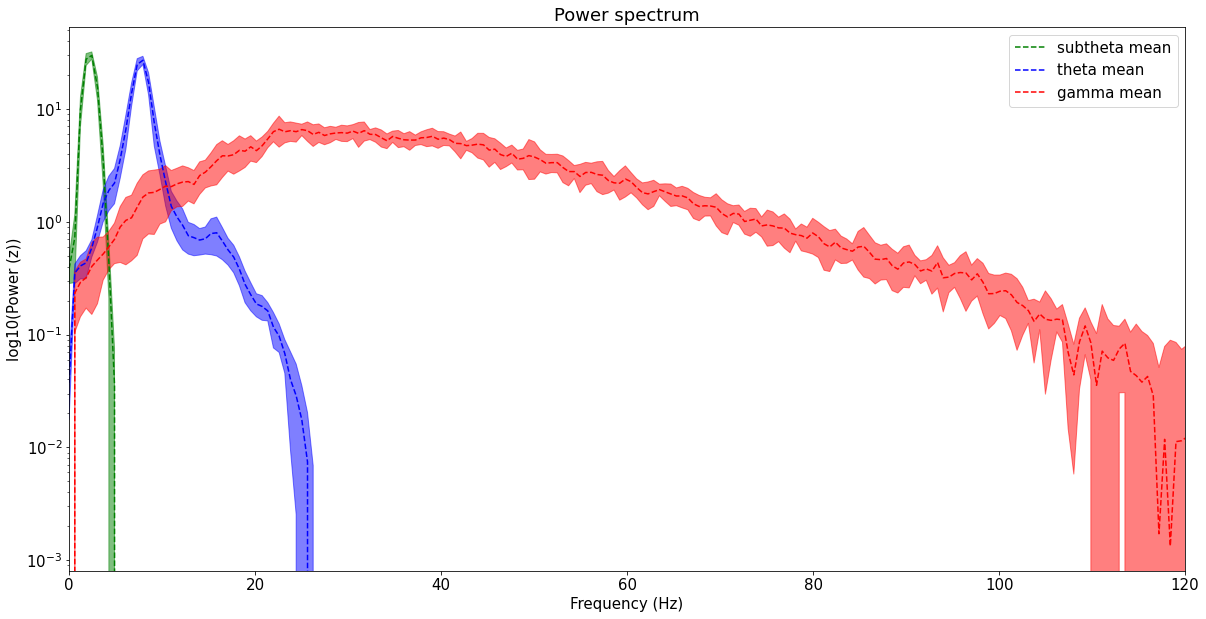

In [ ]:
#@title Power Spectrum of the REM epochs
thetasig=[]
subthetasig=[]
suprathetasig=[]
thetarange=(5,12)
upperdiff=np.floor(1000/np.min(thetarange))
lowerdiff=np.floor(1000/np.max(thetarange))
srate=2500
IMF=[]
for i,rem in enumerate(REM):
  imf,freqvec=emd.sift.iterated_mask_sift(rem,sample_rate=srate,mask_0='zc',ret_mask_freq='True')
  subtheta,theta,supratheta=tgsplit(freqvec)
  thetasig.append(np.sum(imf[:,theta[0]],axis=1))
  subthetasig.append(np.sum(imf[:,subtheta[0]],axis=1))
  suprathetasig.append(np.sum(imf[:,supratheta[0]],axis=1))
f=[]
pspec=[]
for r_e_m in REM:
  f.append(scipy.signal.welch(r_e_m,2500,scaling='spectrum',nperseg=4*1024)[0])
  pspec.append(scipy.stats.zscore(scipy.signal.welch(r_e_m,2500,scaling='spectrum',nperseg=4*1024)[1]))

fsubtheta=[]
subthetapspec=[]
for sub in subthetasig:
  fsubtheta.append(scipy.signal.welch(sub,2500,scaling='spectrum',nperseg=4*1024)[0])
  subthetapspec.append(scipy.stats.zscore(scipy.signal.welch(sub,2500,scaling='spectrum',nperseg=4*1024)[1]))

ftheta=[]
thetapspec=[]
for theta in thetasig:
  ftheta.append(scipy.signal.welch(theta,2500,scaling='spectrum',nperseg=4*1024)[0])
  thetapspec.append(scipy.stats.zscore(scipy.signal.welch(theta,2500,scaling='spectrum',nperseg=4*1024)[1]))

fgamma=[]
gammapspec=[]
for gamma in suprathetasig:
  fgamma.append(scipy.signal.welch(gamma,2500,scaling='spectrum',nperseg=4*1024)[0])
  gammapspec.append(scipy.stats.zscore(scipy.signal.welch(gamma,2500,scaling='spectrum',nperseg=4*1024)[1]))

f=np.array(f)
fsubtheta=np.array(fsubtheta)
ftheta=np.array(ftheta)
fgamma=np.array(fgamma)
pspec=np.array(pspec)
subthetapspec=np.array(subthetapspec)
thetapspec=np.array(thetapspec)
gammapspec=np.array(gammapspec)
plt.gcf().set_size_inches(20, 10)
plt.semilogy(fsubtheta.mean(axis=0),subthetapspec.mean(axis=0),color='green',label='subtheta mean',linestyle='dashed')
plt.semilogy(ftheta.mean(axis=0),thetapspec.mean(axis=0),color='blue',label='theta mean',linestyle='dashed')
plt.semilogy(fgamma.mean(axis=0),gammapspec.mean(axis=0),color='red',label='gamma mean',linestyle='dashed')
plt.fill_between(fsubtheta.mean(axis=0),
                 subthetapspec.std(axis=0)+subthetapspec.mean(axis=0),
                 -subthetapspec.std(axis=0)+subthetapspec.mean(axis=0),
                 alpha=0.5,color='green')
plt.fill_between(ftheta.mean(axis=0),
                 thetapspec.std(axis=0)+thetapspec.mean(axis=0),
                 -thetapspec.std(axis=0)+thetapspec.mean(axis=0),
                 alpha=0.5,color='blue')
plt.fill_between(fgamma.mean(axis=0),
                 gammapspec.std(axis=0)+gammapspec.mean(axis=0),
                 -gammapspec.std(axis=0)+gammapspec.mean(axis=0),
                 alpha=0.5,color='red')
plt.legend(loc='upper right')
plt.xlim(0,120)
plt.ylabel('log10(Power (z))')
plt.xlabel('Frequency (Hz)')
plt.title('Power spectrum')

In [ ]:
#@title Dimensionality Reduction using PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
seed=2005

X=thetacycles.reshape(thetacycles.shape[0],thetacycles.shape[1]*thetacycles.shape[2])
Y=thetacycles2.reshape(thetacycles2.shape[0],thetacycles2.shape[1]*thetacycles2.shape[2])
pca=PCA(n_components=0.85,whiten=True,svd_solver='full')
pcv=pca.fit_transform(X)#15-120Hz
print('1. Theta cycles of FPP (z-scored) reshaped from dimensions '+str(thetacycles.shape[1:])+ '\n' 
      + ' to flattened dimensions of '+str(X.shape[1])
      +' where Principal Component Analysis yields us '+str(pca.n_components_) + ' principal components')
pcv=pca.fit_transform(Y)#15-120Hz
print('2. Theta cycles of FPP (non z-scored) reshaped from dimensions '+str(thetacycles2.shape[1:])+ '\n' 
      + ' to flattened dimensions of '+str(Y.shape[1])+ 
      ' where Principal Component Analysis yields us '+str(pca.n_components_) + ' principal components')

1. Theta cycles of FPP (z-scored) reshaped from dimensions (105, 19)
 to flattened dimensions of 1995 where Principal Component Analysis yields us 30 principal components
2. Theta cycles of FPP (non z-scored) reshaped from dimensions (105, 19)
 to flattened dimensions of 1995 where Principal Component Analysis yields us 16 principal components


Text(0.5, 1.0, 'Spectral Signatures of Theta Cycles non z-scored')

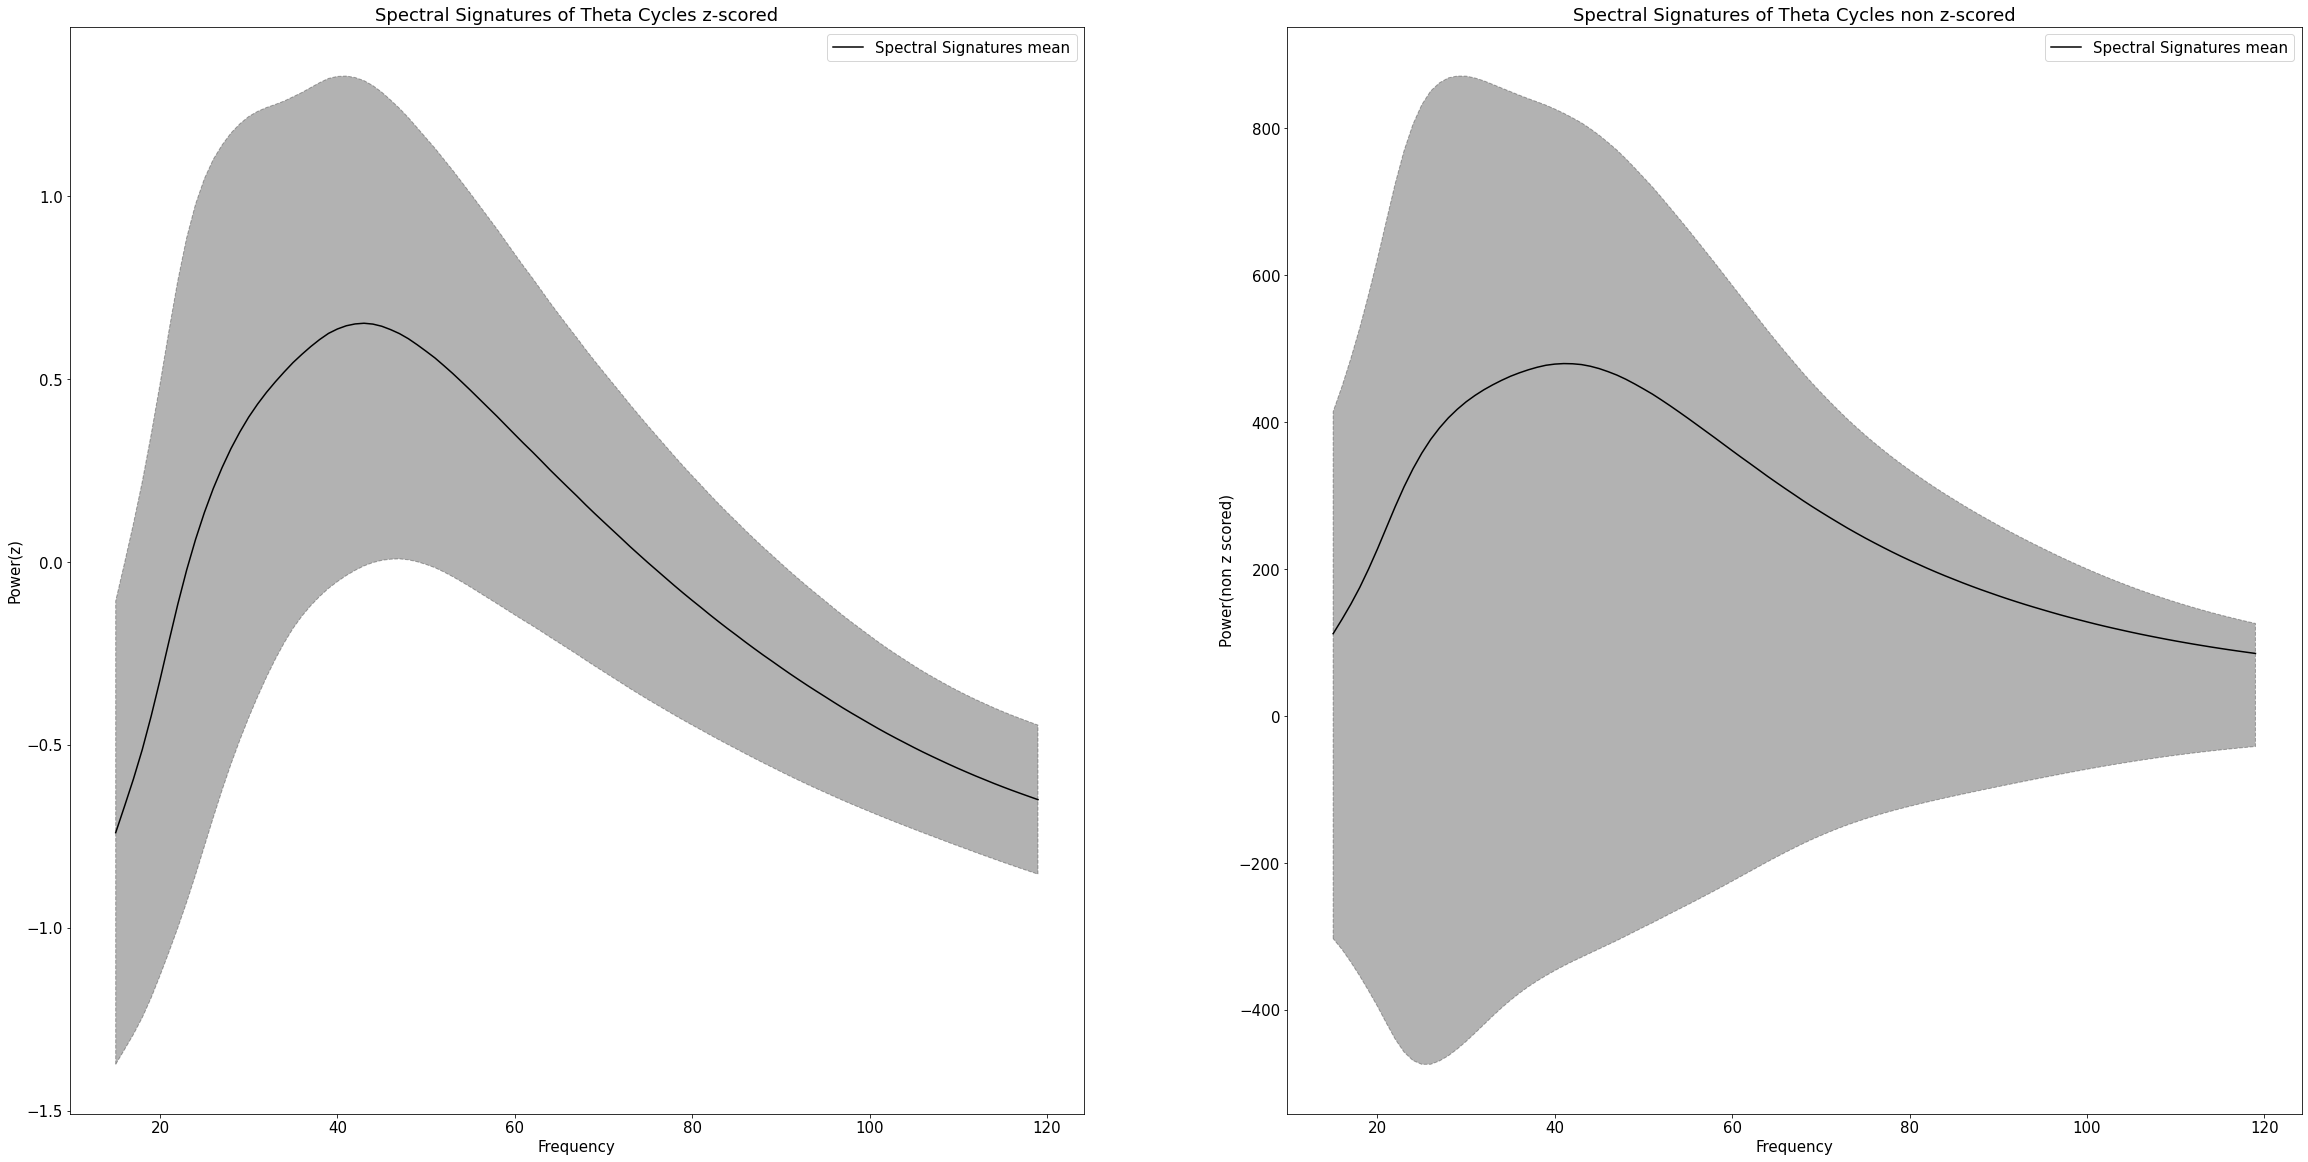

In [ ]:
#@title Dimensionality Reduction using spectral signatures 
#@markdown A clever way of reducing dimensionality is to associate each theta cycle with a curve carrying spectral information of different frequencies within that cycle [(Lopes-dos-Santos, V., Van de Ven, G. M., Morley, A., Trouche, S., Campo-Urriza, N., &amp; Dupret, D., 2018)](https://doi.org/10.1016/j.neuron.2018.09.031)
spectralsigmean=thetacycles.mean(axis=2)
spectralsigmean2=thetacycles2.mean(axis=2)

fig16,ax16=plt.subplots(1,2,sharex=True,figsize=(40,20))
plt.rcParams.update({'font.size': 15})
ax16[0].plot(np.arange(15,120,1),spectralsigmean.mean(axis=0),
             label='Spectral Signatures mean',color='black')
ax16[0].fill_between(np.arange(15,120,1),
                    spectralsigmean.mean(axis=0)+spectralsigmean.std(axis=0),
                    spectralsigmean.mean(axis=0)-spectralsigmean.std(axis=0),
                    linestyle='dashed',color='black',alpha=0.3)
ax16[0].legend(loc='upper right')
ax16[0].set_ylabel('Power(z)')
ax16[0].set_xlabel('Frequency')
ax16[0].set_title('Spectral Signatures of Theta Cycles z-scored')
ax16[1].plot(np.arange(15,120,1),spectralsigmean2.mean(axis=0),
             label='Spectral Signatures mean',color='black')
ax16[1].fill_between(np.arange(15,120,1),
                    spectralsigmean2.mean(axis=0)+spectralsigmean2.std(axis=0),
                    spectralsigmean.mean(axis=0)-spectralsigmean2.std(axis=0),
                    linestyle='dashed',color='black',alpha=0.3)
ax16[1].legend(loc='upper right')
ax16[1].set_ylabel('Power(non z scored)')
ax16[1].set_xlabel('Frequency')
ax16[1].set_title('Spectral Signatures of Theta Cycles non z-scored')

# Analysis of z-scored theta cycles

In [ ]:
#@title Spectral Signatures analysis of Theta Cycles (z-scored)
pcv=pca.fit_transform(spectralsigmean)
print('Theta cycles of FPP (z-scored) reshaped from dimensions '+str(thetacycles.shape[1:])+ '\n' 
      + 'to spectral signatures of dimensions '+str(spectralsigmean.shape[1])
      +' where Principal Component Analysis yields us '+str(pca.n_components_) + ' principal components \n')
ica=FastICA(n_components=pca.n_components_,random_state=seed,whiten='unit-variance')
icv=icv=ica.fit_transform(spectralsigmean)
#tSC Threshold calculation
tSCs_median=np.median(icv,axis=0) # median(p)
print('tSC medians:'+ str(tSCs_median)+'\n')
mask=np.logical_and(icv>=tSCs_median,icv>0) # boolean values that satisfy |p-median(p)|
threshold=[]
for icvs,bl,tscmed in zip(icv.T,mask.T,tSCs_median):
  threshold.append(2*np.std(icvs[bl])+tscmed) # corrected code
thresholdmedian=np.array(threshold)
print('Calculated thresholds:'+str(thresholdmedian)+'\n')
tSCmask=icv>thresholdmedian #boolean array of satisfactory strong tSC components
for t,(icvT,tSCT) in enumerate(zip(icv.T,tSCmask.T)):
  print('#tSC'+str(t+1)+ ' cycles:'+str(icvT[tSCT].shape[0])+',\n')
print('Total number of tSC cycles detected: '+str(icv[tSCmask].shape[0]))

Theta cycles of FPP (z-scored) reshaped from dimensions (105, 19)
to spectral signatures of dimensions 105 where Principal Component Analysis yields us 5 principal components 

tSC medians:[ 0.00120989 -0.0444134   0.00154889  0.1100695  -0.18455426]

Calculated thresholds:[1.19228533 1.17191709 1.11079039 1.0562594  1.73475951]

#tSC1 cycles:364,

#tSC2 cycles:399,

#tSC3 cycles:466,

#tSC4 cycles:392,

#tSC5 cycles:196,

Total number of tSC cycles detected: 1817


Text(0.5, 0.98, 'Individual tSC Distributions calculated from Power(z) cycles 15-120 Hz')

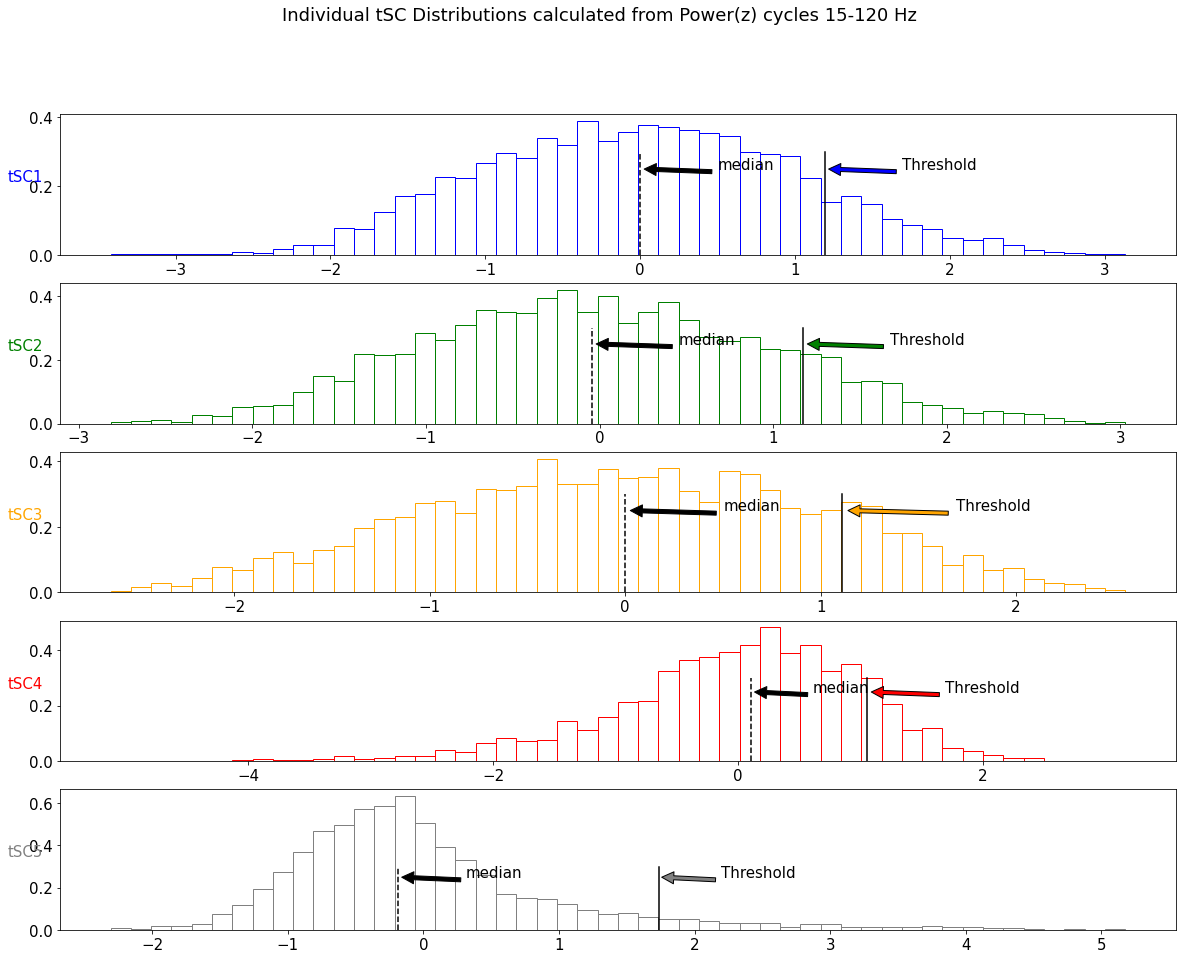

In [ ]:
#@title Distribution plots of tSC cycles
n_bins=50
mediancolor='black'
medianlinestyle='dashed'
fig17,ax17=plt.subplots(icv.shape[1],1,figsize=(20,15))
plt.rcParams.update({'font.size': 15})
ax17[0].set_ylabel(r'tSC1',color='blue',fontsize='medium',rotation='horizontal',position=(1,0.15))
ax17[0].hist(icv[:,0],bins=n_bins,histtype='bar',fill=False,density=True,edgecolor='blue')
ax17[0].plot((np.median(icv[:,0]),np.median(icv[:,0])),(0,0.3),color=mediancolor,linestyle='dashed')
ax17[0].annotate('median',xy=(np.median(icv[:,0]),0.25),xytext=(np.median(icv[:,0])+0.5,0.25),arrowprops=dict(facecolor='black', shrink=0.05))
ax17[0].plot((thresholdmedian[0],thresholdmedian[0]),(0,0.3),color=mediancolor)
ax17[0].annotate('Threshold',xy=(thresholdmedian[0],0.25),xytext=(thresholdmedian[0]+0.5,0.25),arrowprops=dict(facecolor='blue', shrink=0.05))
ax17[1].set_ylabel(r'tSC2',color='green',fontsize='medium',rotation='horizontal',position=(1,0.15))
ax17[1].hist(icv[:,1],bins=n_bins,histtype='bar',fill=False,density=True,edgecolor='green')
ax17[1].plot((np.median(icv[:,1]),np.median(icv[:,1])),(0,0.3),color=mediancolor,linestyle='dashed')
ax17[1].annotate('median',xy=(np.median(icv[:,1]),0.25),xytext=(np.median(icv[:,1])+0.5,0.25),arrowprops=dict(facecolor='black', shrink=0.05))
ax17[1].plot((thresholdmedian[1],thresholdmedian[1]),(0,0.3),color=mediancolor)
ax17[1].annotate('Threshold',xy=(thresholdmedian[1],0.25),xytext=(thresholdmedian[1]+0.5,0.25),arrowprops=dict(facecolor='green', shrink=0.05))
ax17[2].set_ylabel(r'tSC3',color='orange',fontsize='medium',rotation='horizontal',position=(1,0.15))
ax17[2].hist(icv[:,2],bins=n_bins,histtype='bar',fill=False,density=True,edgecolor='orange')
ax17[2].plot((np.median(icv[:,2]),np.median(icv[:,2])),(0,0.3),color=mediancolor,linestyle='dashed')
ax17[2].annotate('median',xy=(np.median(icv[:,2]),0.25),xytext=(np.median(icv[:,2])+0.5,0.25),arrowprops=dict(facecolor='black', shrink=0.05))
ax17[2].plot((thresholdmedian[2],thresholdmedian[2]),(0,0.3),color=mediancolor)
ax17[2].annotate('Threshold',xy=(thresholdmedian[2],0.25),xytext=(thresholdmedian[0]+0.5,0.25),arrowprops=dict(facecolor='orange', shrink=0.05))
ax17[3].set_ylabel(r'tSC4',color='red',fontsize='medium',rotation='horizontal',position=(1,0.15))
ax17[3].hist(icv[:,3],bins=n_bins,histtype='bar',fill=False,density=True,edgecolor='red')
ax17[3].plot((np.median(icv[:,3]),np.median(icv[:,3])),(0,0.3),color=mediancolor,linestyle='dashed')
ax17[3].annotate('median',xy=(np.median(icv[:,3]),0.25),xytext=(np.median(icv[:,3])+0.5,0.25),arrowprops=dict(facecolor='black', shrink=0.05))
ax17[3].plot((thresholdmedian[3],thresholdmedian[3]),(0,0.3),color=mediancolor)
ax17[3].annotate('Threshold',xy=(thresholdmedian[3],0.25),xytext=(thresholdmedian[0]+0.5,0.25),arrowprops=dict(facecolor='red', shrink=0.05))
ax17[4].set_ylabel(r'tSC5',color='gray',fontsize='medium',rotation='horizontal',position=(1,0.15))
ax17[4].hist(icv[:,4],bins=n_bins,histtype='bar',fill=False,density=True,edgecolor='grey')
ax17[4].plot((np.median(icv[:,4]),np.median(icv[:,4])),(0,0.3),color=mediancolor,linestyle='dashed')
ax17[4].annotate('median',xy=(np.median(icv[:,4]),0.25),xytext=(np.median(icv[:,4])+0.5,0.25),arrowprops=dict(facecolor='black', shrink=0.05))
ax17[4].plot((thresholdmedian[4],thresholdmedian[4]),(0,0.3),color=mediancolor)
ax17[4].annotate('Threshold',xy=(thresholdmedian[4],0.25),xytext=(thresholdmedian[0]+1,0.25),arrowprops=dict(facecolor='grey', shrink=0.05))
fig17.suptitle('Individual tSC Distributions calculated from Power(z) cycles 15-120 Hz')

Text(0.5, 0.98, 'Spectral Signatures of identified tSC components calculated from Power(z), 15-120 Hz')

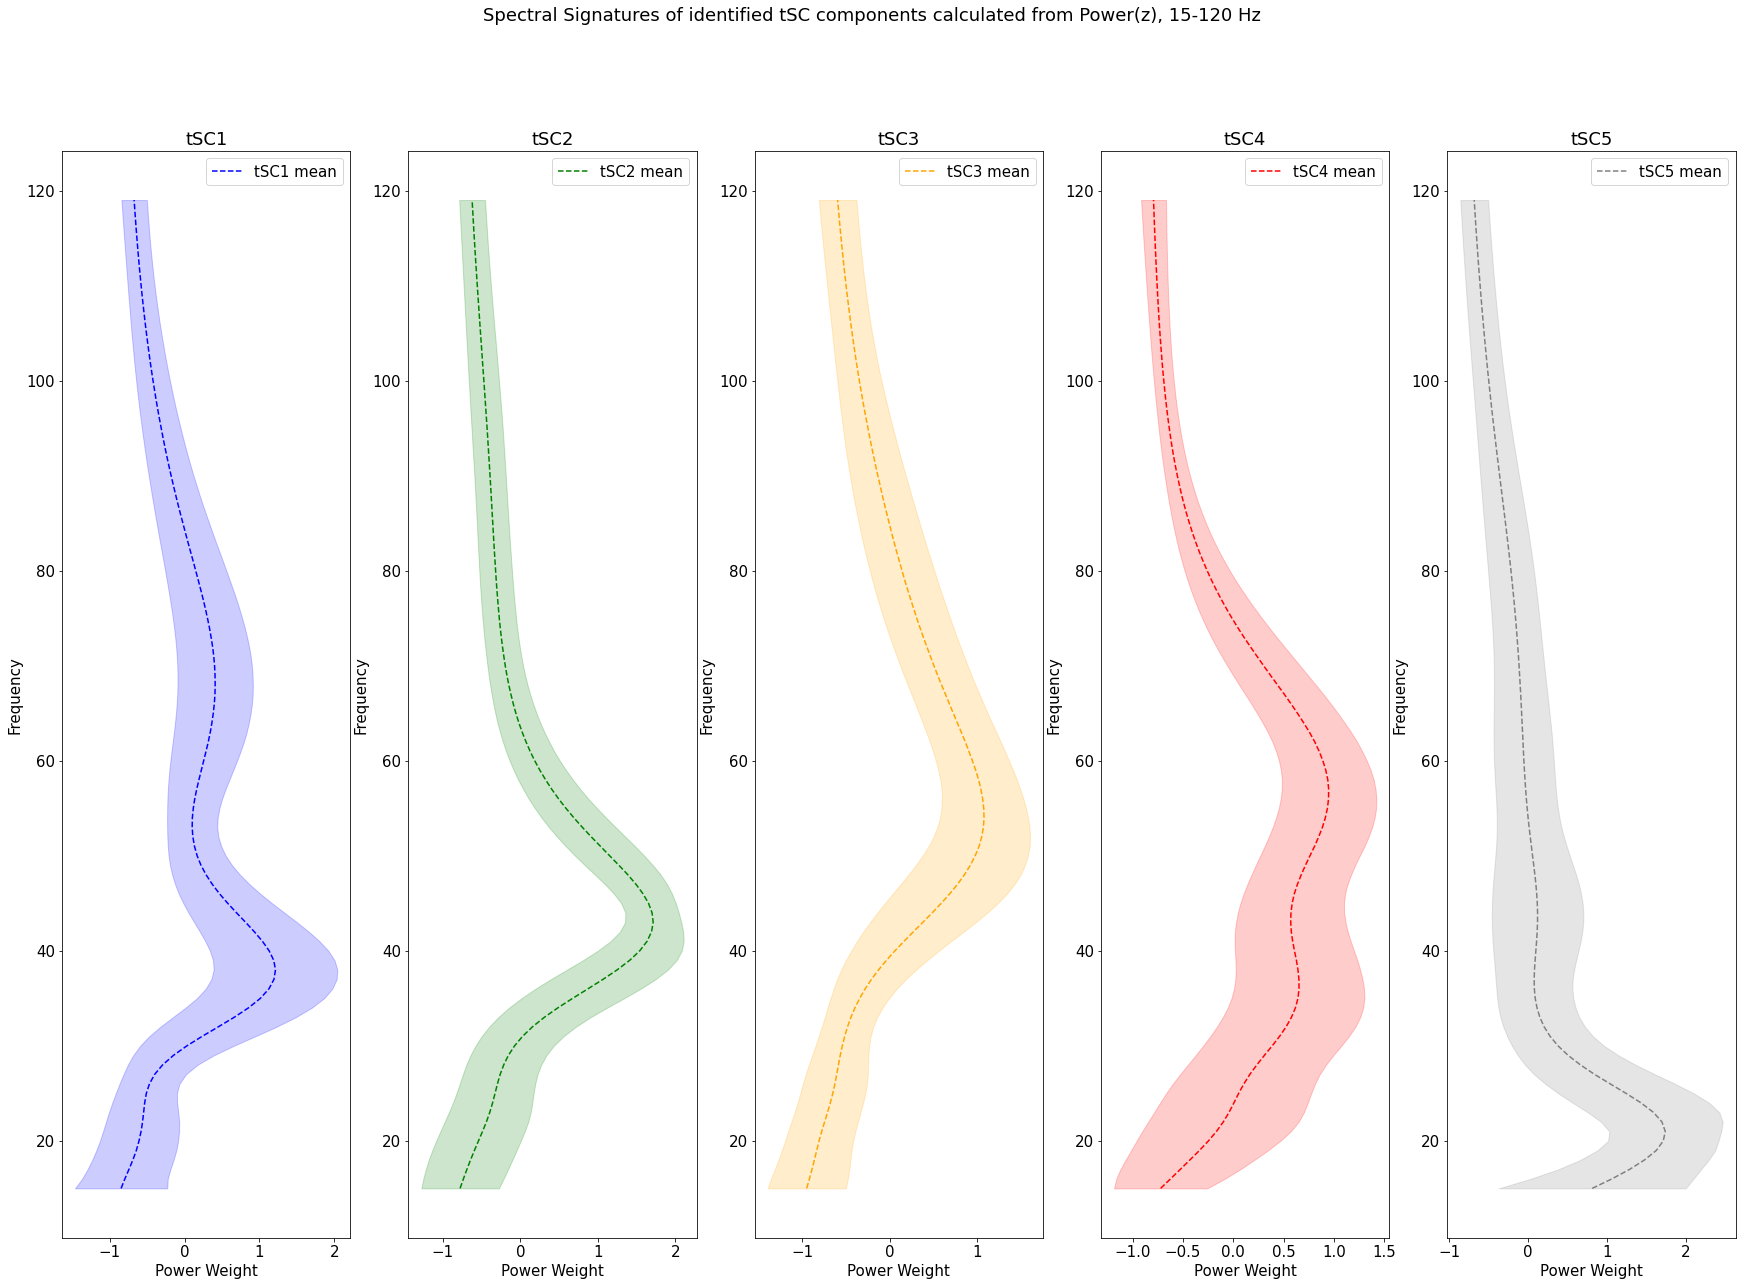

In [ ]:
#@title Spectral Signatures of tSC cycles
tSC1=thetacycles[tSCmask.T[0]]
tSC2=thetacycles[tSCmask.T[1]]
tSC3=thetacycles[tSCmask.T[2]]
tSC4=thetacycles[tSCmask.T[3]]
tSC5=thetacycles[tSCmask.T[4]]

fig18,ax18=plt.subplots(1,icv.shape[1],figsize=(30,20))
plt.rcParams.update({'font.size': 15})
ax18[0].plot(tSC1.mean(axis=2).mean(axis=0),np.arange(15,120,1),color='blue',linestyle='dashed',
              label='tSC1 mean')
ax18[0].fill_betweenx(np.arange(15,120,1),
                       -tSC1.mean(axis=2).std(axis=0)+tSC1.mean(axis=2).mean(axis=0),
                       tSC1.mean(axis=2).std(axis=0)+tSC1.mean(axis=2).mean(axis=0),
                       alpha=0.2,color='blue')
ax18[0].set_xlabel('Power Weight')
ax18[0].set_ylabel('Frequency')
ax18[0].legend(loc='upper right')
ax18[0].set_title('tSC1') 
ax18[1].plot(tSC2.mean(axis=2).mean(axis=0),np.arange(15,120,1),color='green',linestyle='dashed',
              label='tSC2 mean')
ax18[1].fill_betweenx(np.arange(15,120,1),
                       -tSC2.mean(axis=2).std(axis=0)+tSC2.mean(axis=2).mean(axis=0),
                       tSC2.mean(axis=2).std(axis=0)+tSC2.mean(axis=2).mean(axis=0),
                       alpha=0.2,color='green')
ax18[1].set_xlabel('Power Weight')
ax18[1].set_ylabel('Frequency')
ax18[1].legend(loc='upper right')
ax18[1].set_title('tSC2') 
ax18[2].plot(tSC3.mean(axis=2).mean(axis=0),np.arange(15,120,1),color='orange',linestyle='dashed',
              label='tSC3 mean')
ax18[2].fill_betweenx(np.arange(15,120,1),
                       -tSC3.mean(axis=2).std(axis=0)+tSC3.mean(axis=2).mean(axis=0),
                       tSC3.mean(axis=2).std(axis=0)+tSC3.mean(axis=2).mean(axis=0),
                       alpha=0.2,color='orange')
ax18[2].set_xlabel('Power Weight')
ax18[2].set_ylabel('Frequency')
ax18[2].legend(loc='upper right')
ax18[2].set_title('tSC3') 
ax18[3].plot(tSC4.mean(axis=2).mean(axis=0),np.arange(15,120,1),color='red',linestyle='dashed',
              label='tSC4 mean')
ax18[3].fill_betweenx(np.arange(15,120,1),
                       -tSC4.mean(axis=2).std(axis=0)+tSC4.mean(axis=2).mean(axis=0),
                       tSC4.mean(axis=2).std(axis=0)+tSC4.mean(axis=2).mean(axis=0),
                       alpha=0.2,color='red')
ax18[3].set_xlabel('Power Weight')
ax18[3].set_ylabel('Frequency')
ax18[3].legend(loc='upper right')
ax18[3].set_title('tSC4')
ax18[4].plot(tSC5.mean(axis=2).mean(axis=0),np.arange(15,120,1),color='grey',linestyle='dashed',label='tSC5 mean')
ax18[4].fill_betweenx(np.arange(15,120,1),
                       -tSC5.mean(axis=2).std(axis=0)+tSC5.mean(axis=2).mean(axis=0),
                       tSC5.mean(axis=2).std(axis=0)+tSC5.mean(axis=2).mean(axis=0),
                       alpha=0.2,color='grey')
ax18[4].set_xlabel('Power Weight')
ax18[4].set_ylabel('Frequency')
ax18[4].legend(loc='upper right')
ax18[4].set_title('tSC5')
fig18.suptitle ('Spectral Signatures of identified tSC components calculated from Power(z), 15-120 Hz')

Text(0.5, 0.98, 'tSC components FPP averages')

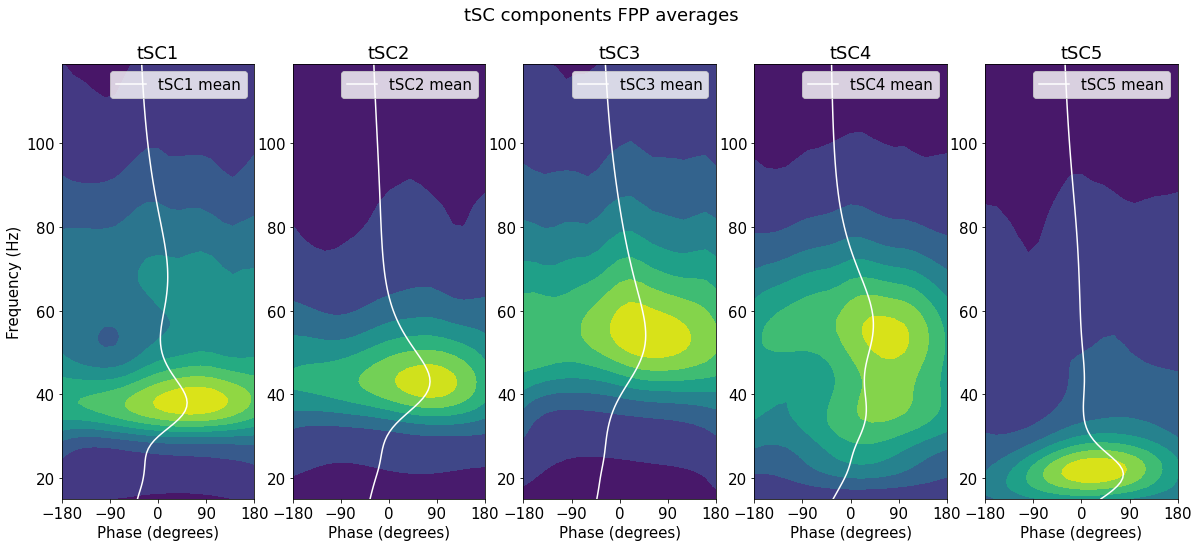

In [ ]:
#@title FPP of tSC Averages

phaseplot=np.linspace(-180,180,19)
tSC1plot=np.where(tSCmask.T[0]==True)
tSC2plot=np.where(tSCmask.T[1]==True)
tSC3plot=np.where(tSCmask.T[2]==True)
tSC4plot=np.where(tSCmask.T[3]==True)
tSC5plot=np.where(tSCmask.T[4]==True)
fig19,ax19=plt.subplots(1,5,figsize=(20,8))
ax19[0].contourf(phaseplot,frequency[15:120],np.average(thetacycles2[tSC1plot],axis=0))
ax19[0].set_xlabel('Phase (degrees)')
ax19[0].set_ylabel('Frequency (Hz)')
ax19[0].set_title('tSC1')
ax19[0].set_xticks([-180,-90,0,90,180])
ax19[0].set_yticks([20,40,60,80,100])
ax19[0].plot(tSC1.mean(axis=2).mean(axis=0)*45,np.arange(15,120,1),color='white',
              label='tSC1 mean')
ax19[0].legend(loc='upper right')
ax19[1].contourf(phaseplot,frequency[15:120],np.average(thetacycles2[tSC2plot],axis=0))
ax19[1].set_xlabel('Phase (degrees)')
ax19[1].set_title('tSC2')
ax19[1].set_xticks([-180,-90,0,90,180])
ax19[1].set_yticks([20,40,60,80,100])
ax19[1].plot(tSC2.mean(axis=2).mean(axis=0)*45,np.arange(15,120,1),color='white',
              label='tSC2 mean')
ax19[1].legend(loc='upper right')

ax19[2].contourf(phaseplot,frequency[15:120],np.average(thetacycles2[tSC3plot],axis=0))
ax19[2].set_xlabel('Phase (degrees)')
ax19[2].set_title('tSC3')
ax19[2].set_xticks([-180,-90,0,90,180])
ax19[2].set_yticks([20,40,60,80,100])
ax19[2].plot(tSC3.mean(axis=2).mean(axis=0)*45,np.arange(15,120,1),color='white',
              label='tSC3 mean')
ax19[2].legend(loc='upper right')

ax19[3].contourf(phaseplot,frequency[15:120],np.average(thetacycles2[tSC4plot],axis=0))
ax19[3].set_xlabel('Phase (degrees)')
ax19[3].set_title('tSC4')
ax19[3].set_xticks([-180,-90,0,90,180])
ax19[3].set_yticks([20,40,60,80,100])
ax19[3].plot(tSC4.mean(axis=2).mean(axis=0)*45,np.arange(15,120,1),color='white',
              label='tSC4 mean')
ax19[3].legend(loc='upper right')

ax19[4].contourf(phaseplot,frequency[15:120],np.average(thetacycles2[tSC5plot],axis=0))
ax19[4].set_xlabel('Phase (degrees)')
ax19[4].set_title('tSC5')
ax19[4].set_xticks([-180,-90,0,90,180])
ax19[4].set_yticks([20,40,60,80,100])
ax19[4].plot(tSC5.mean(axis=2).mean(axis=0)*45,np.arange(15,120,1),color='white',
              label='tSC5 mean')
ax19[4].legend(loc='upper right')




fig19.suptitle('tSC components FPP averages')

# Analysis of non z-scored theta cycles

In [ ]:
#@title Spectral Signatures analysis of Theta Cycles (non- z-scored)
pcv=pca.fit_transform(spectralsigmean2)
print('Theta cycles of FPP (non- z-scored) reshaped from dimensions '+str(thetacycles2.shape[1:])+ '\n' 
      + 'to spectral signatures of dimensions '+str(spectralsigmean2.shape[1])
      +' where Principal Component Analysis yields us '+str(pca.n_components_) + ' principal components \n')
ica=FastICA(n_components=pca.n_components_,random_state=seed,whiten='unit-variance')
icv=icv=ica.fit_transform(spectralsigmean2)
#tSC Threshold calculation
tSCs_median=np.median(icv,axis=0) # median(p)
print('tSC medians:'+ str(tSCs_median)+'\n')
mask=np.logical_and(icv>=tSCs_median,icv>0) # boolean values that satisfy |p-median(p)|
threshold=[]
for icvs,bl,tscmed in zip(icv.T,mask.T,tSCs_median):
  threshold.append(2*np.std(icvs[bl])+tscmed) # corrected code
thresholdmedian=np.array(threshold)
print('Calculated thresholds:'+str(thresholdmedian)+'\n')
tSCmask=icv>thresholdmedian #boolean array of satisfactory strong tSC components
for t,(icvT,tSCT) in enumerate(zip(icv.T,tSCmask.T)):
  print('#tSC'+str(t+1)+ ' cycles:'+str(icvT[tSCT].shape[0])+',\n')
print('Total number of tSC cycles detected: '+str(icv[tSCmask].shape[0]))

Theta cycles of FPP (non- z-scored) reshaped from dimensions (105, 19)
to spectral signatures of dimensions 105 where Principal Component Analysis yields us 3 principal components 

tSC medians:[ 0.21040275  0.27277826 -0.21658376]

Calculated thresholds:[0.89017975 0.72994943 1.71323697]

#tSC1 cycles:429,

#tSC2 cycles:253,

#tSC3 cycles:171,

Total number of tSC cycles detected: 853


Text(0.5, 0.98, 'Individual tSC Distributions calculated from Power(non-z) cycles 15-120 Hz')

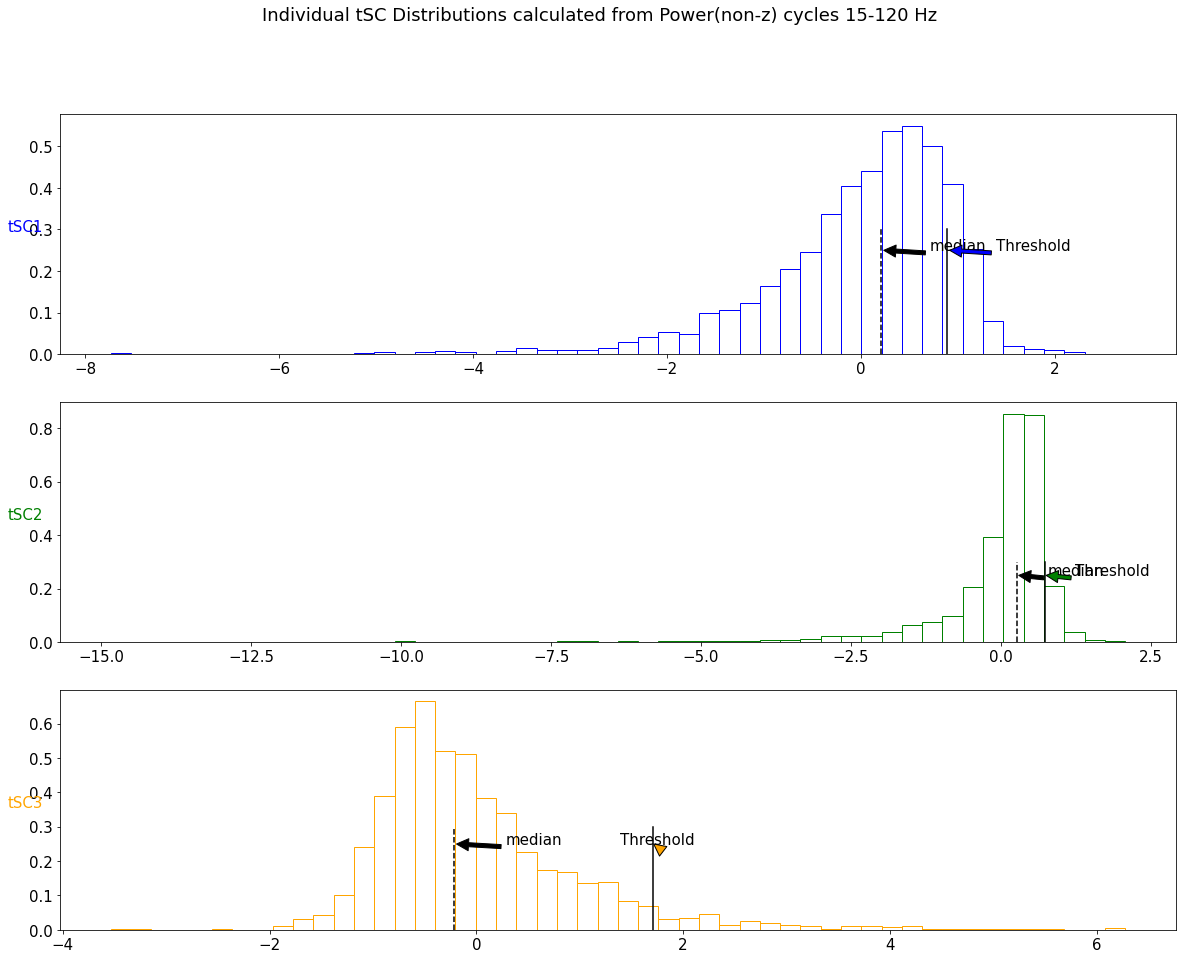

In [ ]:
#@title Distribution plots of tSC cycles
n_bins=50
mediancolor='black'
medianlinestyle='dashed'
fig21,ax21=plt.subplots(icv.shape[1],1,figsize=(20,15))
plt.rcParams.update({'font.size': 15})
ax21[0].set_ylabel(r'tSC1',color='blue',fontsize='medium',rotation='horizontal',position=(1,0.15))
ax21[0].hist(icv[:,0],bins=n_bins,histtype='bar',fill=False,density=True,edgecolor='blue')
ax21[0].plot((np.median(icv[:,0]),np.median(icv[:,0])),(0,0.3),color=mediancolor,linestyle='dashed')
ax21[0].annotate('median',xy=(np.median(icv[:,0]),0.25),xytext=(np.median(icv[:,0])+0.5,0.25),arrowprops=dict(facecolor='black', shrink=0.05))
ax21[0].plot((thresholdmedian[0],thresholdmedian[0]),(0,0.3),color=mediancolor)
ax21[0].annotate('Threshold',xy=(thresholdmedian[0],0.25),xytext=(thresholdmedian[0]+0.5,0.25),arrowprops=dict(facecolor='blue', shrink=0.05))
ax21[1].set_ylabel(r'tSC2',color='green',fontsize='medium',rotation='horizontal',position=(1,0.15))
ax21[1].hist(icv[:,1],bins=n_bins,histtype='bar',fill=False,density=True,edgecolor='green')
ax21[1].plot((np.median(icv[:,1]),np.median(icv[:,1])),(0,0.3),color=mediancolor,linestyle='dashed')
ax21[1].annotate('median',xy=(np.median(icv[:,1]),0.25),xytext=(np.median(icv[:,1])+0.5,0.25),arrowprops=dict(facecolor='black', shrink=0.05))
ax21[1].plot((thresholdmedian[1],thresholdmedian[1]),(0,0.3),color=mediancolor)
ax21[1].annotate('Threshold',xy=(thresholdmedian[1],0.25),xytext=(thresholdmedian[1]+0.5,0.25),arrowprops=dict(facecolor='green', shrink=0.05))
ax21[2].set_ylabel(r'tSC3',color='orange',fontsize='medium',rotation='horizontal',position=(1,0.15))
ax21[2].hist(icv[:,2],bins=n_bins,histtype='bar',fill=False,density=True,edgecolor='orange')
ax21[2].plot((np.median(icv[:,2]),np.median(icv[:,2])),(0,0.3),color=mediancolor,linestyle='dashed')
ax21[2].annotate('median',xy=(np.median(icv[:,2]),0.25),xytext=(np.median(icv[:,2])+0.5,0.25),arrowprops=dict(facecolor='black', shrink=0.05))
ax21[2].plot((thresholdmedian[2],thresholdmedian[2]),(0,0.3),color=mediancolor)
ax21[2].annotate('Threshold',xy=(thresholdmedian[2],0.25),xytext=(thresholdmedian[0]+0.5,0.25),arrowprops=dict(facecolor='orange', shrink=0.05))
fig21.suptitle('Individual tSC Distributions calculated from Power(non-z) cycles 15-120 Hz')

Text(0.5, 0.98, 'Spectral Signatures of identified tSC components calculated from Power(z), 15-120 Hz')

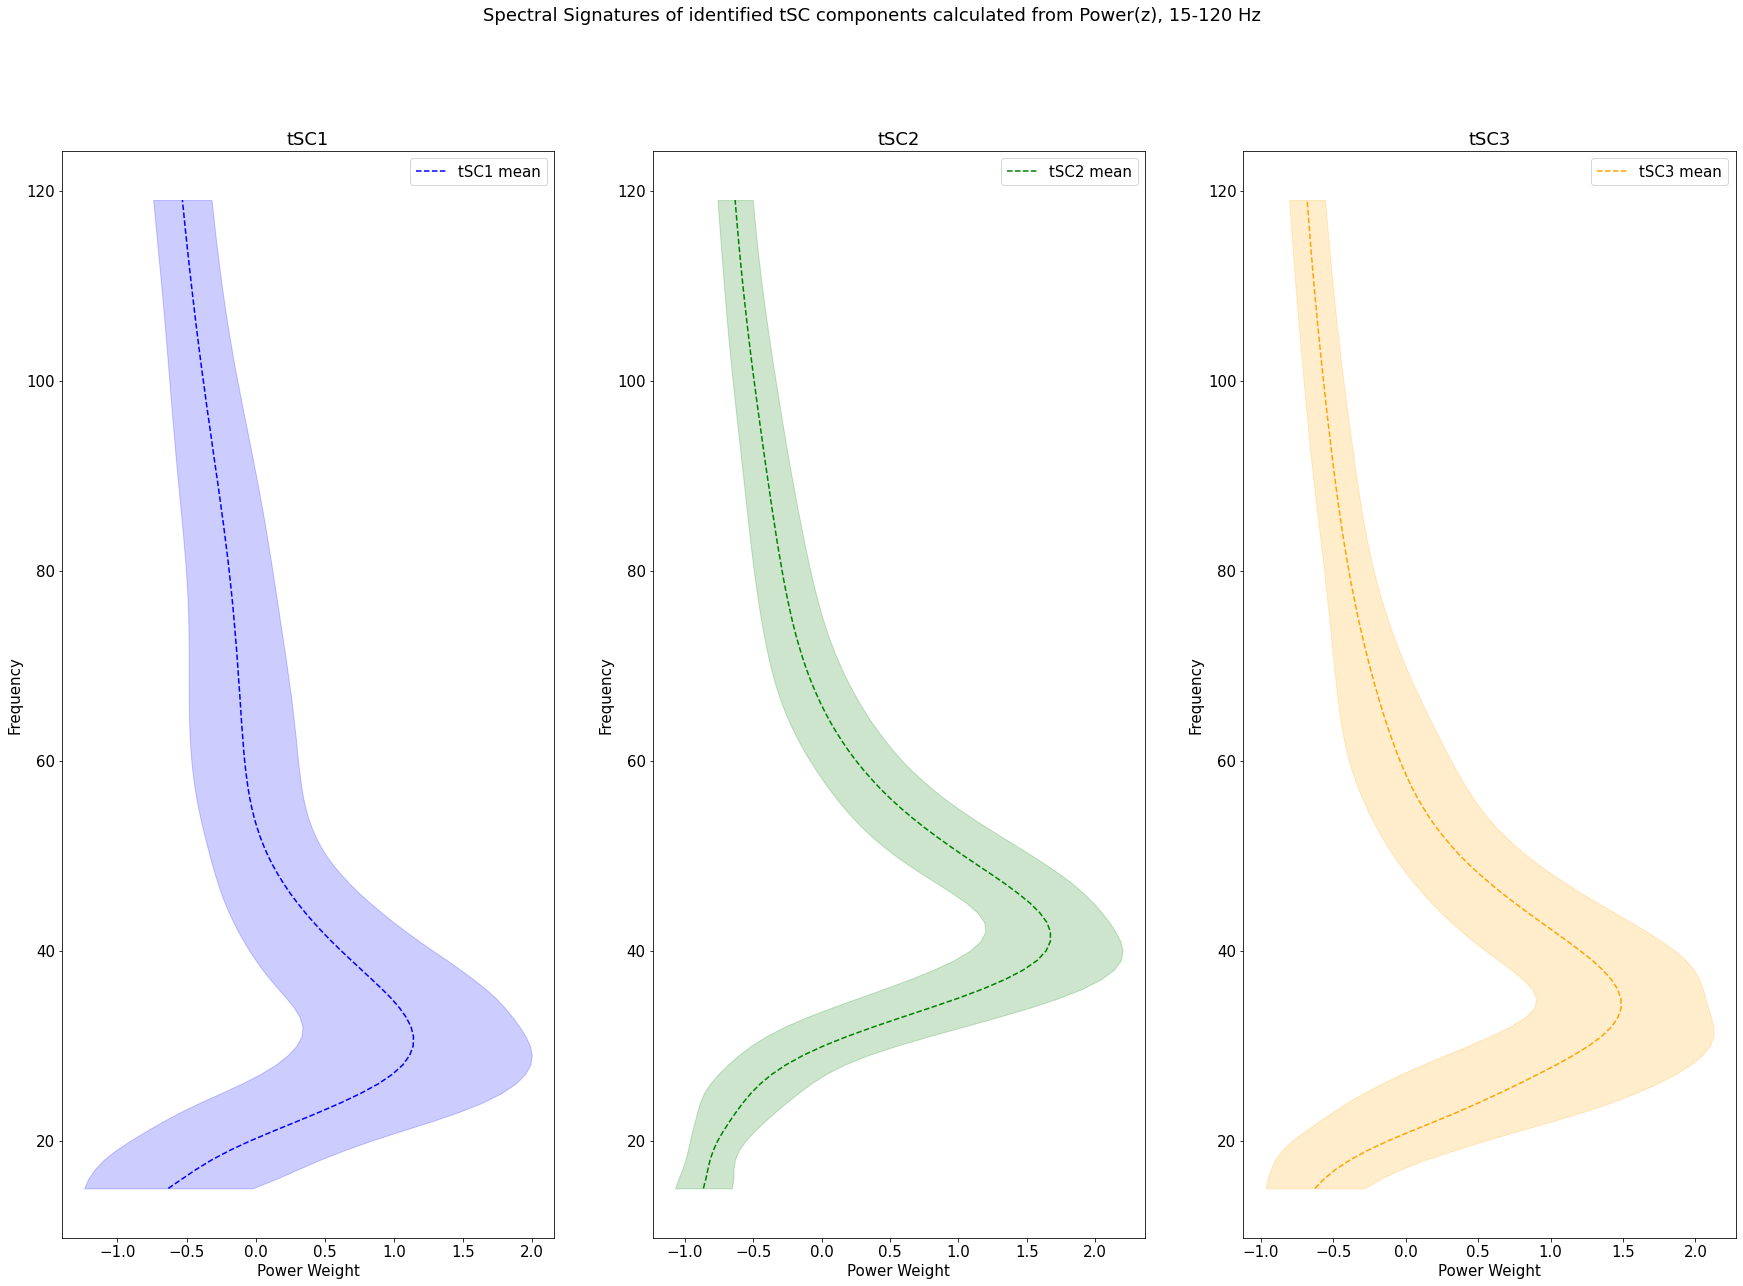

In [ ]:
#@title Spectral Signatures of tSC cycles
tSC1=thetacycles[tSCmask.T[0]]
tSC2=thetacycles[tSCmask.T[1]]
tSC3=thetacycles[tSCmask.T[2]]


fig20,ax20=plt.subplots(1,icv.shape[1],figsize=(30,20))
plt.rcParams.update({'font.size': 15})
ax20[0].plot(tSC1.mean(axis=2).mean(axis=0),np.arange(15,120,1),color='blue',linestyle='dashed',
              label='tSC1 mean')
ax20[0].fill_betweenx(np.arange(15,120,1),
                       -tSC1.mean(axis=2).std(axis=0)+tSC1.mean(axis=2).mean(axis=0),
                       tSC1.mean(axis=2).std(axis=0)+tSC1.mean(axis=2).mean(axis=0),
                       alpha=0.2,color='blue')
ax20[0].set_xlabel('Power Weight')
ax20[0].set_ylabel('Frequency')
ax20[0].legend(loc='upper right')
ax20[0].set_title('tSC1') 
ax20[1].plot(tSC2.mean(axis=2).mean(axis=0),np.arange(15,120,1),color='green',linestyle='dashed',
              label='tSC2 mean')
ax20[1].fill_betweenx(np.arange(15,120,1),
                       -tSC2.mean(axis=2).std(axis=0)+tSC2.mean(axis=2).mean(axis=0),
                       tSC2.mean(axis=2).std(axis=0)+tSC2.mean(axis=2).mean(axis=0),
                       alpha=0.2,color='green')
ax20[1].set_xlabel('Power Weight')
ax20[1].set_ylabel('Frequency')
ax20[1].legend(loc='upper right')
ax20[1].set_title('tSC2') 
ax20[2].plot(tSC3.mean(axis=2).mean(axis=0),np.arange(15,120,1),color='orange',linestyle='dashed',
              label='tSC3 mean')
ax20[2].fill_betweenx(np.arange(15,120,1),
                       -tSC3.mean(axis=2).std(axis=0)+tSC3.mean(axis=2).mean(axis=0),
                       tSC3.mean(axis=2).std(axis=0)+tSC3.mean(axis=2).mean(axis=0),
                       alpha=0.2,color='orange')
ax20[2].set_xlabel('Power Weight')
ax20[2].set_ylabel('Frequency')
ax20[2].legend(loc='upper right')
ax20[2].set_title('tSC3') 
fig20.suptitle ('Spectral Signatures of identified tSC components calculated from Power(z), 15-120 Hz')

Text(0.5, 0.98, 'tSC components FPP averages')

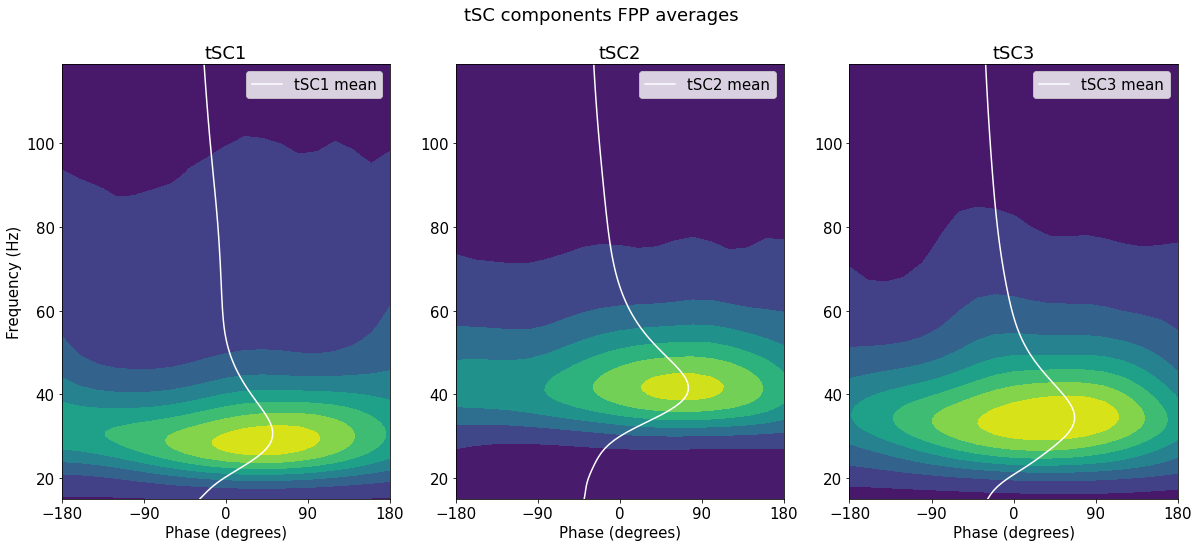

In [ ]:
#@title FPP of tSC Averages

tSC1plot=np.where(tSCmask.T[0]==True)
tSC2plot=np.where(tSCmask.T[1]==True)
tSC3plot=np.where(tSCmask.T[2]==True)
fig21,ax21=plt.subplots(1,3,figsize=(20,8))
ax21[0].contourf(phaseplot,frequency[15:120],np.average(thetacycles2[tSC1plot],axis=0))
ax21[0].set_xlabel('Phase (degrees)')
ax21[0].set_ylabel('Frequency (Hz)')
ax21[0].set_title('tSC1')
ax21[0].set_xticks([-180,-90,0,90,180])
ax21[0].set_yticks([20,40,60,80,100])
ax21[0].plot(tSC1.mean(axis=2).mean(axis=0)*45,np.arange(15,120,1),color='white',
              label='tSC1 mean')
ax21[0].legend(loc='upper right')
ax21[1].contourf(phaseplot,frequency[15:120],np.average(thetacycles2[tSC2plot],axis=0))
ax21[1].set_xlabel('Phase (degrees)')
ax21[1].set_title('tSC2')
ax21[1].set_xticks([-180,-90,0,90,180])
ax21[1].set_yticks([20,40,60,80,100])
ax21[1].plot(tSC2.mean(axis=2).mean(axis=0)*45,np.arange(15,120,1),color='white',
              label='tSC2 mean')
ax21[1].legend(loc='upper right')

ax21[2].contourf(phaseplot,frequency[15:120],np.average(thetacycles2[tSC3plot],axis=0))
ax21[2].set_xlabel('Phase (degrees)')
ax21[2].set_title('tSC3')
ax21[2].set_xticks([-180,-90,0,90,180])
ax21[2].set_yticks([20,40,60,80,100])
ax21[2].plot(tSC3.mean(axis=2).mean(axis=0)*45,np.arange(15,120,1),color='white',
              label='tSC3 mean')
ax21[2].legend(loc='upper right')




fig21.suptitle('tSC components FPP averages')